__Proyecto__: Predicción de temperatura a la salida del Horno de Afino <br>
__Fecha de inicio__: 23 agosto 2022 <br>
__Desarrollo__: Aracely Mtz <br>
__Modificado__: Aracely Mtz <br>

# Objective

Preparar los datos para el modelo

# Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import math
import datetime
import statistics#

## Clases y definiciones

In [2]:
sys.path.append("../../..")

In [3]:
from utils.utils import PlotHistBoxplot, PlotPredictionRes,outliersIQR, PlotMissingBar, caida_temp, PlotCurvasTemp

# Carga de datos

In [4]:
df_ollas = pd.read_csv("../../data/data_modelo/ControlOllas/ControlOllas-2021-2022.csv")
df_tot_raw = pd.read_csv("data/CT_totales_RAW.csv")

df_tot = pd.read_csv("data/CT_totales.csv")
df_temp = pd.read_csv("data/CT_caida_temp.csv")

In [5]:
df_ollas.head()

,FECHA,TURNO,OLLA,COLADA,COL OLLA,COL BOQ,TAPON COL,TAPON AGITAC,TAPON ACUMULADO,TON ACERO,OLLA INI-FIN,OBSERVACIONES
0,01/01/2021,9,31.0,120984,110.0,27.0,14.0,46.0,598,136.0,NaN,NaN
1,01/01/2021,8,21.0,120985,62.0,1.0,16.0,52.0,666,133.0,NaN,NaN
2,01/01/2021,8,22.0,120986,39.0,13.0,39.0,44.0,1591,133.0,NaN,NaN
3,01/01/2021,8,33.0,120987,8.0,8.0,8.0,36.0,327,133.0,NaN,NaN
4,01/01/2021,8,31.0,120988,111.0,28.0,15.0,27.0,625,136.0,NaN,NaN


In [6]:
# Eliminamos donde el número de olla es null
df_ollas[["OLLA", "COL OLLA"]].isna().sum()

OLLA        246
COL OLLA    285
dtype: int64

In [7]:
df_ollas = df_ollas[~df_ollas["OLLA"].isna()]

In [8]:
# Eliminamos donde el número de olla es null
df_ollas[["OLLA", "COL OLLA"]].isna().sum()

OLLA         0
COL OLLA    39
dtype: int64

In [9]:
df_ollas.groupby("OLLA").size()

OLLA
10.0     706
11.0     629
12.0     604
13.0     644
21.0    1975
22.0    2127
24.0     637
27.0     333
28.0     671
29.0    2187
30.0    1973
31.0    2164
32.0    2166
33.0    2045
dtype: int64

In [10]:
df_ollas.columns

Index(['FECHA', 'TURNO', 'OLLA', 'COLADA', 'COL OLLA', 'COL BOQ', 'TAPON COL',
       'TAPON AGITAC', 'TAPON ACUMULADO', 'TON ACERO', 'OLLA INI-FIN',
       'OBSERVACIONES'],
      dtype='object')

# Preparación de variables

Control de ollas:
* Revisar fechas
* Revisar duplicados
* Solo datos 2021 y 2022
* Conservar variale de COL OLLA y TON ACERO

* Guardar solo aquellas donde hay datos tanto de totales como de temperatura

LADLE_LIFE <br>
* Calculadas:
    * TUNDISH_HEAT_COUNTER <br>
    * LADLE_EMPTY_TIME <br>
    * LADLE_FULL_TIME_CURRENT <br>
    * CASTING_TIME-TARGET <br>
    * TRANSFER_TIME_RS_CCM-TARGET <br>
    
LADLE_TOTAL_WEIGHT_RS <br>
STEELGRADE_FAMILY <br>
LIQUIDUS_TEMPERATURE <br>
SECONDARY_REFINING_ARRIV_TEMP <br>
TEMPERATURE_CCM-TARGET <br>
SUPERHEAT_TEMPERATURE-TARGET

## Datos LADLE LIFE

In [11]:
df_ollas.head(3)

,FECHA,TURNO,OLLA,COLADA,COL OLLA,COL BOQ,TAPON COL,TAPON AGITAC,TAPON ACUMULADO,TON ACERO,OLLA INI-FIN,OBSERVACIONES
0,01/01/2021,9,31.0,120984,110.0,27.0,14.0,46.0,598,136.0,NaN,NaN
1,01/01/2021,8,21.0,120985,62.0,1.0,16.0,52.0,666,133.0,NaN,NaN
2,01/01/2021,8,22.0,120986,39.0,13.0,39.0,44.0,1591,133.0,NaN,NaN


In [12]:
df_ollas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18861 entries, 0 to 19036
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FECHA            14902 non-null  object 
 1   TURNO            14918 non-null  object 
 2   OLLA             18861 non-null  float64
 3   COLADA           18861 non-null  int64  
 4   COL OLLA         18822 non-null  float64
 5   COL BOQ          18822 non-null  float64
 6   TAPON COL        18821 non-null  float64
 7   TAPON AGITAC     15786 non-null  float64
 8   TAPON ACUMULADO  13801 non-null  object 
 9   TON ACERO        17331 non-null  float64
 10  OLLA INI-FIN     1308 non-null   object 
 11  OBSERVACIONES    120 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 1.9+ MB


In [13]:
df_ollas.rename(columns = {"COL OLLA": "LADLE_LIFE", "COLADA": "cla_colada"}, inplace = True)

In [14]:
df_ollas.set_index("cla_colada", inplace = True)

In [15]:
# Quitar duplicados

print("Número de coladas duplicadas: ", len(df_ollas[df_ollas.index.duplicated(keep = False)].index.unique()))

Número de coladas duplicadas:  93


In [16]:
# Quitar coladas duplicadas

df_ollas = df_ollas[~df_ollas.index.duplicated(keep = False)]
df_ollas.shape

(18673, 11)

In [17]:
df_ollas.head()

,FECHA,TURNO,OLLA,LADLE_LIFE,COL BOQ,TAPON COL,TAPON AGITAC,TAPON ACUMULADO,TON ACERO,OLLA INI-FIN,OBSERVACIONES
cla_colada,,,,,,,,,,,
120984,01/01/2021,9,31.0,110.0,27.0,14.0,46.0,598,136.0,NaN,NaN
120985,01/01/2021,8,21.0,62.0,1.0,16.0,52.0,666,133.0,NaN,NaN
120986,01/01/2021,8,22.0,39.0,13.0,39.0,44.0,1591,133.0,NaN,NaN
120987,01/01/2021,8,33.0,8.0,8.0,8.0,36.0,327,133.0,NaN,NaN
120988,01/01/2021,8,31.0,111.0,28.0,15.0,27.0,625,136.0,NaN,NaN


In [18]:
# Agregar la variable al dataset preprocesado

#df_tot.head(1)

#df_tot.sort_values(["cla_horno", "cla_colada", "num_tratamiento"], ascending = True, inplace = True)
#df_tot.head()

In [19]:
df_tot.set_index("cla_colada", inplace = True)
df_tot["LADLE_LIFE"] = 0
df_tot.loc[:,"LADLE_LIFE"] = df_ollas.loc[:, "LADLE_LIFE"] ##Validado

In [20]:
df_tot["LADLE_LIFE"].describe()

count    12711.000000
mean        51.789631
std         30.982523
min          1.000000
25%         26.000000
50%         51.000000
75%         77.000000
max        588.000000
Name: LADLE_LIFE, dtype: float64

## Datos TUNDISH_HEAT_COUNTER
* Number of heats treated by the ladle
* Esta variable se calcula por horno y del dataset crudo por consecutividad de coladas

In [21]:
df_tot_raw.head(3)

,fecha_administrativa,cla_colada,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,fhr_ini,fhr_fin,...,lquim_f3,lquim_f4,lquim_f5,fecha_inicio_vaciado,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max
0,2022-09-30 00:00:00,196762,2,NaN,NaN,NaN,NaN,NaN,2022-09-30 00:13:26,2022-09-30 00:13:26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 00:00:00,120985,3,NaN,0.0,1.0,39.0,132.67395,2020-12-31 19:13:24,2020-12-31 19:58:04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 00:00:00,120986,3,NaN,0.0,1.0,39.0,132.67395,2020-12-31 19:58:04,2020-12-31 20:51:51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Crear la columna de vida de olla con la variable hay_distri

# Ordenamos por horno y por colada
df_tot_raw.sort_values(["cla_horno", "cla_colada", "num_tratamiento"], ascending = True, inplace = True)
df_tot_raw.shape

(33778, 48)

In [23]:
df_tot_raw.head()

,fecha_administrativa,cla_colada,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,fhr_ini,fhr_fin,...,lquim_f3,lquim_f4,lquim_f5,fecha_inicio_vaciado,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max
24,2021-01-01 00:00:00,179752,2,NaN,0.0,1.0,27.0,124.49934,2020-12-31 18:28:34,2020-12-31 19:19:11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,2021-01-01 00:00:00,179753,2,NaN,0.0,1.0,27.0,106.71372,2020-12-31 19:19:11,2020-12-31 20:03:15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,2021-01-01 00:00:00,179754,2,NaN,0.0,1.0,27.0,142.28496,2020-12-31 20:03:15,2020-12-31 20:46:41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,2021-01-01 00:00:00,179755,2,NaN,0.0,1.0,27.0,121.53507,2020-12-31 20:46:41,2020-12-31 21:33:44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,2021-01-01 00:00:00,179756,2,NaN,0.0,1.0,27.0,118.57080,2020-12-31 21:33:44,2020-12-31 22:15:54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_tot_raw = df_tot_raw[~df_tot_raw.set_index("cla_colada").index.duplicated(keep = "last")]
df_tot_raw.shape

(32607, 48)

In [25]:
df_tot_raw.reset_index(drop = True, inplace = True)

In [26]:
df_tot_raw[['cla_colada','cla_horno','hay_distri']]

,cla_colada,cla_horno,hay_distri
0,179752,2,0.0
1,179753,2,0.0
2,179754,2,0.0
3,179755,2,0.0
4,179756,2,0.0
...,...,...,...
32602,136575,3,0.0
32603,136576,3,NaN
32604,136577,3,NaN
32605,136578,3,NaN


In [27]:
df_tot_raw['hay_distri'].value_counts()

0.0    31524
1.0      951
Name: hay_distri, dtype: int64

In [28]:
#pd.set_option('display.max_rows', 33000)

#df_tot_raw[['cla_colada','cla_horno','hay_distri','TUNDISH_HEAT_COUNTER']]


In [29]:
df_tot_raw["TUNDISH_HEAT_COUNTER"] = 1

for horno in [2, 3]: # Para cada horno
    df_tmp = df_tot_raw[df_tot_raw["cla_horno"] == horno].copy()
    idxini = df_tmp.index[0] # indice donde empieza el data set del horno correspondiente
    idxfin = df_tmp.index[-1] # ultimo indice donde empieza el data set del horno correspondiente
    idxs = df_tmp[df_tmp["hay_distri"] == 1].index.to_list()
    
    for i in range(len(idxs)-1):
        a, b = idxs[i], idxs[i+1]-1
        df_tot_raw.loc[a:b, "TUNDISH_HEAT_COUNTER"] = df_tmp.loc[a:b, "TUNDISH_HEAT_COUNTER"].cumsum()
    
    df_tot_raw.loc[idxini: idxs[0], "TUNDISH_HEAT_COUNTER"] = 0 # 0 Indica que no se puede determinar el N° de coladas que llevaba
    df_tot_raw.loc[idxs[-1]: idxfin, "TUNDISH_HEAT_COUNTER"] = df_tmp.loc[idxs[-1]:, "TUNDISH_HEAT_COUNTER"].cumsum()
    
    print("Listo Horno: ", horno)

Listo Horno:  2
Listo Horno:  3


In [30]:
df_tot_raw.tail(5)

,fecha_administrativa,cla_colada,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,fhr_ini,fhr_fin,...,lquim_f4,lquim_f5,fecha_inicio_vaciado,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max,TUNDISH_HEAT_COUNTER
32602,2022-09-30 00:00:00,136575,3,NaN,0.0,1.0,42.0,135.9369,2022-09-29 20:56:48,2022-09-29 21:39:57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
32603,2022-09-30 00:00:00,136576,3,NaN,NaN,NaN,NaN,NaN,2022-09-29 21:39:57,2022-09-29 22:32:13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23
32604,2022-09-30 00:00:00,136577,3,NaN,NaN,NaN,NaN,NaN,2022-09-29 22:32:13,2022-09-29 23:21:09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
32605,2022-09-30 00:00:00,136578,3,NaN,NaN,NaN,NaN,NaN,2022-09-29 23:21:09,2022-09-30 00:00:27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
32606,2022-09-30 00:00:00,136579,3,NaN,NaN,NaN,NaN,NaN,2022-09-30 00:00:27,2022-09-30 00:00:27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26


In [31]:
# Agregamos la variable al dataset preprocesado
df_tot.head(2)

,fecha_administrativa,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,fhr_ini,fhr_fin,fecha_hr_ini_trat,...,fecha_inicio_vaciado,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max,tipo_colada,t_liquidus,LADLE_LIFE
cla_colada,,,,,,,,,,,,,,,,,,,,,
123200,2021-03-30 00:00:00,3,1.0,0.0,1.0,26.0,100.78518,2021-03-29 19:36:33,2021-03-29 20:32:48,2021-03-29 20:39:07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,secuencia,1503.92396,9.0
123201,2021-03-30 00:00:00,3,1.0,0.0,1.0,26.0,162.15705,2021-03-29 20:32:48,2021-03-29 21:31:19,2021-03-29 21:37:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,secuencia,1508.83157,102.0


In [32]:
df_tot["TUNDISH_HEAT_COUNTER"] = 0

df_tot_raw.set_index("cla_colada", inplace = True)

In [33]:
df_tot.loc[:,"TUNDISH_HEAT_COUNTER"] = df_tot_raw.loc[:, "TUNDISH_HEAT_COUNTER"] ##Validado

In [34]:
df_tot["TUNDISH_HEAT_COUNTER"].describe()

count    20595.000000
mean        27.040544
std         25.330891
min          1.000000
25%         10.000000
50%         20.000000
75%         35.000000
max        164.000000
Name: TUNDISH_HEAT_COUNTER, dtype: float64

## LADLE_EMPTY_TIME
Esta variable debe calcularse en el dataset crudo con coladas consecutivas y por horno y por olla porque depende de la colada anterior

In [35]:
df_tot_raw.head(2)

,fecha_administrativa,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,fhr_ini,fhr_fin,fecha_hr_ini_trat,...,lquim_f4,lquim_f5,fecha_inicio_vaciado,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max,TUNDISH_HEAT_COUNTER
cla_colada,,,,,,,,,,,,,,,,,,,,,
179752,2021-01-01 00:00:00,2,NaN,0.0,1.0,27.0,124.49934,2020-12-31 18:28:34,2020-12-31 19:19:11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
179753,2021-01-01 00:00:00,2,NaN,0.0,1.0,27.0,106.71372,2020-12-31 19:19:11,2020-12-31 20:03:15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [36]:
df_tot_raw.shape

(32607, 48)

In [37]:
df_tot_raw[["fecha_inicio_vaciado", "fecha_fin_vaciado","fhr_abre_vd", "fhr_cierre_vd", 
            "min_duracion_vaciado", "tiempo_contacto"]].dropna().head(5)

,fecha_inicio_vaciado,fecha_fin_vaciado,fhr_abre_vd,fhr_cierre_vd,min_duracion_vaciado,tiempo_contacto
cla_colada,,,,,,
184331,2021-06-15 19:10:07,2021-06-15 19:14:06,2021-06-15 20:02:00,2021-06-15 20:49:00,3.983333,99.0
184332,2021-06-15 20:01:29,2021-06-15 20:04:21,2021-06-15 20:52:00,2021-06-15 21:25:00,2.866666,84.0
184333,2021-06-15 22:35:40,2021-06-15 22:39:13,2021-06-15 23:32:00,2021-06-16 00:14:00,3.550000,99.0
184335,2021-06-15 23:55:51,2021-06-15 23:59:50,2021-06-16 01:04:00,2021-06-16 01:51:00,3.983333,116.0
184336,2021-06-16 00:37:43,2021-06-16 00:41:23,2021-06-16 01:52:00,2021-06-16 02:32:00,3.666666,115.0


In [38]:
# Convertimos a formato fecha-hora

for ele in ["fecha_inicio_vaciado", "fecha_fin_vaciado", "fecha_hr_ini_trat", "fecha_hr_fin_trat","fhr_abre_vd", "fhr_cierre_vd"]:
    df_tot_raw[ele] = pd.to_datetime(df_tot_raw[ele])

In [39]:
df_tot_raw.head(1)

,fecha_administrativa,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,fhr_ini,fhr_fin,fecha_hr_ini_trat,...,lquim_f4,lquim_f5,fecha_inicio_vaciado,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max,TUNDISH_HEAT_COUNTER
cla_colada,,,,,,,,,,,,,,,,,,,,,
179752,2021-01-01 00:00:00,2,NaN,0.0,1.0,27.0,124.49934,2020-12-31 18:28:34,2020-12-31 19:19:11,NaT,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,0


In [40]:
df_ollas.head(1)

,FECHA,TURNO,OLLA,LADLE_LIFE,COL BOQ,TAPON COL,TAPON AGITAC,TAPON ACUMULADO,TON ACERO,OLLA INI-FIN,OBSERVACIONES
cla_colada,,,,,,,,,,,
120984,01/01/2021,9,31.0,110.0,27.0,14.0,46.0,598,136.0,NaN,NaN


In [41]:
df_ollas["OLLA"].unique()

array([31., 21., 22., 33., 30., 32., 29., 24., 28., 10., 27., 11., 12.,
       13.])

In [42]:
df_ollas.shape, df_tot_raw.shape

((18673, 11), (32607, 48))

In [43]:
# Definimos un dataset temporal

df_tmp = df_ollas[["OLLA", "LADLE_LIFE"]].join(df_tot_raw)

In [44]:
len([ele for ele in df_ollas.index if ele not in df_tot_raw.index])

0

In [45]:
df_tmp.reset_index(inplace = True)

In [46]:
df_tmp.sort_values(["cla_horno", "OLLA", "cla_colada"], inplace = True)

In [47]:
# Separamos por horno
df1 = df_tmp[df_tmp["cla_horno"] == 2]
df2 = df_tmp[df_tmp["cla_horno"] == 3]

In [48]:
df1.shape, df2.shape

((4176, 51), (14497, 51))

In [49]:
df1.head()

,cla_colada,OLLA,LADLE_LIFE,fecha_administrativa,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,...,lquim_f4,lquim_f5,fecha_inicio_vaciado,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max,TUNDISH_HEAT_COUNTER
14604,189587,10.0,1.0,2022-01-06 00:00:00,2,1.0,0.0,1.0,35.0,103.74945,...,0.0,0.0,2022-01-05 20:40:50,2022-01-05 20:43:26,2.600000,111.0,27.0,20.0,30.0,5
14608,189591,10.0,2.0,2022-01-06 00:00:00,2,1.0,0.0,1.0,35.0,121.53507,...,0.0,0.0,2022-01-05 23:34:34,2022-01-05 23:36:48,2.233333,102.0,27.0,20.0,30.0,9
14611,189594,10.0,3.0,2022-01-06 00:00:00,2,1.0,0.0,1.0,35.0,97.82091,...,0.0,0.0,2022-01-06 01:45:26,2022-01-06 01:47:53,2.450000,106.0,23.0,20.0,30.0,12
14615,189598,10.0,4.0,2022-01-06 00:00:00,2,1.0,0.0,1.0,35.0,112.64226,...,0.0,0.0,2022-01-06 04:44:13,2022-01-06 04:48:11,3.966666,109.0,27.0,20.0,30.0,16
14619,189602,10.0,5.0,2022-01-06 00:00:00,2,1.0,0.0,1.0,35.0,115.60653,...,0.0,0.0,2022-01-06 07:22:48,2022-01-06 07:26:48,4.000000,117.0,32.0,20.0,30.0,20


In [50]:
print("Total de coladas con variables de tiempo en null H1:", 
      df1[["fecha_inicio_vaciado", "fhr_cierre_vd"]].isna().any(axis = 1).sum())
print("Total de coladas con variables de tiempo en null H2:", 
      df2[["fecha_inicio_vaciado", "fhr_cierre_vd"]].isna().any(axis = 1).sum())

Total de coladas con variables de tiempo en null H1: 308
Total de coladas con variables de tiempo en null H2: 5631


In [51]:
df2[df2[["fecha_inicio_vaciado", "fhr_cierre_vd"]].isna().any(axis = 1)][["cla_colada", "cla_horno", "fecha_inicio_vaciado", "fhr_cierre_vd"]]

,cla_colada,cla_horno,fecha_inicio_vaciado,fhr_cierre_vd
13063,134115,3,NaT,NaT
1,120985,3,NaT,2020-12-31 22:00:00
5,120989,3,NaT,2021-01-01 00:48:00
9,120993,3,NaT,2021-01-01 04:02:00
13,120997,3,NaT,2021-01-01 07:26:00
...,...,...,...,...
13497,134557,3,NaT,2022-06-26 10:47:00
13501,134561,3,NaT,2022-06-26 13:36:00
13541,134601,3,NaT,2022-06-27 20:41:00
13921,134982,3,NaT,2022-07-11 14:03:00


In [52]:
df2.sort_values("fecha_administrativa")

,cla_colada,OLLA,LADLE_LIFE,fecha_administrativa,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,...,lquim_f4,lquim_f5,fecha_inicio_vaciado,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max,TUNDISH_HEAT_COUNTER
0,120984,31.0,110.0,2021-01-01 00:00:00,3,NaN,0.0,1.0,39.0,135.62226,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,0
8,120992,31.0,112.0,2021-01-01 00:00:00,3,NaN,0.0,1.0,39.0,132.67395,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,0
12,120996,31.0,113.0,2021-01-01 00:00:00,3,NaN,0.0,1.0,39.0,132.67395,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,0
16,121000,31.0,114.0,2021-01-01 00:00:00,3,NaN,0.0,1.0,39.0,135.62226,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,0
20,121004,31.0,115.0,2021-01-01 00:00:00,3,NaN,0.0,1.0,39.0,138.57057,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,135541,21.0,77.0,2022-08-08 00:00:00,3,1.0,0.0,1.0,46.0,135.93690,...,0.0,0.0,2022-08-07 19:42:49,2022-08-07 19:46:13,3.400000,157.0,25.9071,22.6377,27.5377,16
14482,135544,32.0,47.0,2022-08-08 00:00:00,3,1.0,0.0,1.0,46.0,138.89205,...,0.0,0.0,2022-08-07 22:26:49,2022-08-07 22:30:12,3.383333,162.0,35.3155,33.4838,39.8838,19
14486,135548,32.0,48.0,2022-08-08 00:00:00,3,1.0,0.0,1.0,46.0,135.93690,...,0.0,0.0,2022-08-08 02:48:11,2022-08-08 02:51:35,3.400000,111.0,33.5467,18.2344,36.8344,23
14494,135556,22.0,4.0,2022-08-08 00:00:00,3,1.0,0.0,1.0,25.0,130.02660,...,0.0,0.0,2022-08-08 15:32:12,2022-08-08 15:34:52,2.666666,115.0,NaN,NaN,NaN,2


In [53]:
# Creamos variable de cierre de la colada anterior
df1["fhr_cierre_vd_ant"] = df1["fhr_cierre_vd"].shift().values
df2["fhr_cierre_vd_ant"] = df2["fhr_cierre_vd"].shift().values

/tmp/ipykernel_333119/499358937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["fhr_cierre_vd_ant"] = df1["fhr_cierre_vd"].shift().values
/tmp/ipykernel_333119/499358937.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["fhr_cierre_vd_ant"] = df2["fhr_cierre_vd"].shift().values


In [54]:
df1[["OLLA", "LADLE_LIFE", "fhr_cierre_vd_ant", "fecha_inicio_vaciado", "fhr_cierre_vd"]]

,OLLA,LADLE_LIFE,fhr_cierre_vd_ant,fecha_inicio_vaciado,fhr_cierre_vd
14604,10.0,1.0,NaT,2022-01-05 20:40:50,2022-01-05 22:31:00
14608,10.0,2.0,2022-01-05 22:31:00,2022-01-05 23:34:34,2022-01-06 01:16:00
14611,10.0,3.0,2022-01-06 01:16:00,2022-01-06 01:45:26,2022-01-06 03:31:00
14615,10.0,4.0,2022-01-06 03:31:00,2022-01-06 04:44:13,2022-01-06 06:33:00
14619,10.0,5.0,2022-01-06 06:33:00,2022-01-06 07:22:48,2022-01-06 09:19:00
...,...,...,...,...,...
18498,28.0,73.0,2022-05-26 09:50:00,2022-05-26 11:26:24,2022-05-26 13:15:00
18502,28.0,74.0,2022-05-26 13:15:00,2022-05-26 14:34:23,2022-05-26 15:57:00
18661,28.0,39.0,2022-05-26 15:57:00,2022-05-31 21:21:25,2022-05-31 23:13:00
18665,28.0,40.0,2022-05-31 23:13:00,2022-06-01 00:47:41,2022-06-01 02:36:00


In [55]:
# Calculamos la diferencia en tiempo desde el cierre de la colada anterior hasta el inicio del vaciado de la colada actual
df1["LADLE_EMPTY_TIME"] = (df1["fecha_inicio_vaciado"] - df1["fhr_cierre_vd_ant"]).apply(lambda x: x.seconds/60)
df2["LADLE_EMPTY_TIME"] = (df2["fecha_inicio_vaciado"] - df2["fhr_cierre_vd_ant"]).apply(lambda x: x.seconds/60)

/tmp/ipykernel_333119/1851481828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["LADLE_EMPTY_TIME"] = (df1["fecha_inicio_vaciado"] - df1["fhr_cierre_vd_ant"]).apply(lambda x: x.seconds/60)
/tmp/ipykernel_333119/1851481828.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["LADLE_EMPTY_TIME"] = (df2["fecha_inicio_vaciado"] - df2["fhr_cierre_vd_ant"]).apply(lambda x: x.seconds/60)


In [56]:
print("Total de coladas con variables de tiempo en null H1:", 
      df1[["fecha_inicio_vaciado", "fhr_cierre_vd", "LADLE_EMPTY_TIME"]].isna().any(axis = 1).sum())
print("Total de coladas con variables de tiempo en null H2:", 
      df2[["fecha_inicio_vaciado", "fhr_cierre_vd", "LADLE_EMPTY_TIME"]].isna().any(axis = 1).sum())

Total de coladas con variables de tiempo en null H1: 332
Total de coladas con variables de tiempo en null H2: 5649


In [57]:
# Volvemos a agrupar ambos hornos
df_tmp = df1.append(df2)

In [58]:
# Agregamos la variable al dataset preprocesado
df_tmp.head(2)

,cla_colada,OLLA,LADLE_LIFE,fecha_administrativa,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,...,fecha_inicio_vaciado,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max,TUNDISH_HEAT_COUNTER,fhr_cierre_vd_ant,LADLE_EMPTY_TIME
14604,189587,10.0,1.0,2022-01-06 00:00:00,2,1.0,0.0,1.0,35.0,103.74945,...,2022-01-05 20:40:50,2022-01-05 20:43:26,2.600000,111.0,27.0,20.0,30.0,5,NaT,NaN
14608,189591,10.0,2.0,2022-01-06 00:00:00,2,1.0,0.0,1.0,35.0,121.53507,...,2022-01-05 23:34:34,2022-01-05 23:36:48,2.233333,102.0,27.0,20.0,30.0,9,2022-01-05 22:31:00,63.566667


In [59]:
resultados_limpieza = pd.DataFrame(columns = ["descripcion", "H1", "H2"])
resultados_limpieza

,descripcion,H1,H2


In [60]:
# Revisamos el número de coladas por horno en datos de control de ollas
Nhorno = df_tmp.groupby("cla_horno").size().values
Nhorno

array([ 4176, 14497])

In [61]:
resultados_limpieza = resultados_limpieza.append(pd.DataFrame({
    "descripcion": "Número de coladas por horno en datos de control de ollas",
    "H1": Nhorno[0], 
    "H2": Nhorno[1]}, index = [0]))
resultados_limpieza

,descripcion,H1,H2
0,Número de coladas por horno en datos de contro...,4176,14497


In [62]:
df_tmp.set_index("cla_colada", inplace = True)
df_tmp.head(1)

,OLLA,LADLE_LIFE,fecha_administrativa,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,fhr_ini,...,fecha_inicio_vaciado,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max,TUNDISH_HEAT_COUNTER,fhr_cierre_vd_ant,LADLE_EMPTY_TIME
cla_colada,,,,,,,,,,,,,,,,,,,,,
189587,10.0,1.0,2022-01-06 00:00:00,2,1.0,0.0,1.0,35.0,103.74945,2022-01-05 20:05:56,...,2022-01-05 20:40:50,2022-01-05 20:43:26,2.6,111.0,27.0,20.0,30.0,5,NaT,NaN


In [63]:
df_tot.head(1)

,fecha_administrativa,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,fhr_ini,fhr_fin,fecha_hr_ini_trat,...,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max,tipo_colada,t_liquidus,LADLE_LIFE,TUNDISH_HEAT_COUNTER
cla_colada,,,,,,,,,,,,,,,,,,,,,
123200,2021-03-30 00:00:00,3,1.0,0.0,1.0,26.0,100.78518,2021-03-29 19:36:33,2021-03-29 20:32:48,2021-03-29 20:39:07,...,NaN,NaN,NaN,NaN,NaN,NaN,secuencia,1503.92396,9.0,36.0


In [64]:
# Agregamos la variable al dataset preprocesado
df_tot["LADLE_EMPTY_TIME"] = 0
df_tot.loc[:,"LADLE_EMPTY_TIME"] = df_tmp.loc[:, "LADLE_EMPTY_TIME"] ##Validado

In [65]:
df_tot.describe()

,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,tpo_min_total,lquim_al,lquim_b,lquim_c,...,lquim_f5,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max,t_liquidus,LADLE_LIFE,TUNDISH_HEAT_COUNTER,LADLE_EMPTY_TIME
count,21325.000000,21325.0,21307.000000,21307.000000,21307.000000,21321.000000,20529.000000,20483.000000,20483.000000,20483.000000,...,20483.0,15571.000000,15571.00000,11624.000000,11624.000000,11624.000000,20483.000000,12711.000000,20595.000000,9549.000000
mean,2.540633,1.0,0.024828,0.975172,33.188107,125.702289,37.152662,26.197474,5.280779,0.271114,...,0.0,3.130059,116.57453,21.776836,9.541631,23.719985,1506.263062,51.789631,27.040544,117.938983
std,0.498358,0.0,0.155603,0.155603,7.287830,14.084811,10.382797,15.363395,13.630399,0.173022,...,0.0,0.560158,100.07192,93.926145,110.081604,91.252872,15.607278,30.982523,25.330891,213.090197
min,2.000000,1.0,0.000000,0.000000,6.000000,20.638170,0.000000,0.000000,0.000000,0.012000,...,0.0,0.000000,36.00000,-1471.863300,-1471.863300,-1471.863300,1461.325220,1.000000,1.000000,0.033333
25%,2.000000,1.0,0.000000,1.000000,28.000000,115.606530,30.366700,23.000000,0.000000,0.084000,...,0.0,2.783333,100.00000,25.597750,18.000000,28.000000,1497.247905,26.000000,10.000000,50.616667
50%,3.000000,1.0,0.000000,1.000000,33.000000,129.725640,37.350000,26.000000,1.000000,0.277800,...,0.0,3.283333,110.00000,29.000000,20.000000,30.000000,1502.072800,51.000000,20.000000,67.166667
75%,3.000000,1.0,0.000000,1.000000,39.000000,135.622260,43.333300,29.000000,2.000000,0.369900,...,0.0,3.400000,121.00000,33.000000,20.000000,32.000000,1523.837030,77.000000,35.000000,86.033333
max,3.000000,1.0,1.000000,1.000000,46.000000,229.968180,169.200000,1882.000000,78.000000,0.846000,...,0.0,4.016666,6659.00000,272.776600,272.776600,272.776600,1533.784110,588.000000,164.000000,1439.566667


In [66]:
# Nos quedamos con las coladas de control de ollas que sí estan en el dataset preprocesado
df_tot = df_tot.loc[[ele for ele in df_tot.index if ele in df_tmp.index]]

In [67]:
df_tot.groupby("cla_horno").size()

cla_horno
2    2806
3    9925
dtype: int64

In [68]:
Nhorno = df_tot.groupby("cla_horno").size().values

In [69]:
resultados_limpieza = resultados_limpieza.append(pd.DataFrame({
    "descripcion": "Coladas uniendo dataset preprocesado con Control de ollas",
    "H1": Nhorno[0], 
    "H2": Nhorno[1]}, index = [0]))
resultados_limpieza

,descripcion,H1,H2
0,Número de coladas por horno en datos de contro...,4176,14497
0,Coladas uniendo dataset preprocesado con Contr...,2806,9925


In [70]:
# Datos donde LADLE_EMPTY_TIME es vacio
df_tot[~df_tot["LADLE_EMPTY_TIME"].isna()].groupby("cla_horno").size()

cla_horno
2    2599
3    6950
dtype: int64

## LADLE_FULL_TIME_CURRENT

Total time of ladle with steel, since the ladle is filled with steel at EAF tapping until the arriving of the ladle to LFcurrent heat

**PENDIENTE**

Desde que termina en EAF hasta que llega a Afino

In [71]:
for ele in ["fecha_hr_ini_trat", "fecha_inicio_vaciado"]:
    df_tot[ele] = pd.to_datetime(df_tot[ele])

In [72]:
for horno in [2,3]:
    print(f"Total de coladas con variables de tiempo en null {horno}:", 
          df_tot[df_tot[["fecha_hr_ini_trat", "fecha_inicio_vaciado"]].isna().any(axis = 1)&(df_tot["cla_horno"]==horno)].shape)

Total de coladas con variables de tiempo en null 2: (176, 52)
Total de coladas con variables de tiempo en null 3: (2968, 52)


In [73]:
df_tot["LADLE_FULL_TIME_CURRENT"] = df_tot["fecha_hr_ini_trat"] - df_tot["fecha_inicio_vaciado"]
df_tot["LADLE_FULL_TIME_CURRENT"] = df_tot["LADLE_FULL_TIME_CURRENT"].apply(lambda x: x.seconds/60)

In [74]:
df_tot["LADLE_FULL_TIME_CURRENT"].describe()

count    9587.000000
mean       16.923120
std        26.211618
min         3.316667
25%        10.550000
50%        14.066667
75%        19.233333
max      1429.266667
Name: LADLE_FULL_TIME_CURRENT, dtype: float64

In [75]:
for horno in [2,3]:
    print(f"Total de coladas con variables de tiempo en null {horno}:", 
          df_tot[df_tot[["fecha_hr_ini_trat", "fecha_inicio_vaciado", "LADLE_FULL_TIME_CURRENT"]].isna().any(axis = 1)&(df_tot["cla_horno"]==horno)].shape)

Total de coladas con variables de tiempo en null 2: (176, 53)
Total de coladas con variables de tiempo en null 3: (2968, 53)


## CASTING_TIME -TARGET

Total casting time

In [76]:
for ele in ["fhr_cierre_vd", "fhr_abre_vd"]:
    df_tot[ele] = pd.to_datetime(df_tot[ele])

In [77]:
df_tot["CASTING_TIME"] = (df_tot["fhr_cierre_vd"] - df_tot["fhr_abre_vd"]).apply(lambda x: x.seconds/60)

<AxesSubplot:xlabel='CASTING_TIME', ylabel='Count'>

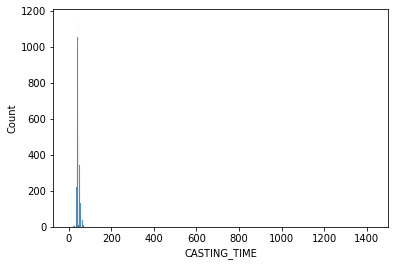

In [78]:
sns.histplot(df_tot["CASTING_TIME"])

In [79]:
df_tot["CASTING_TIME"].describe()

count    12710.000000
mean        46.342149
std         23.607193
min          0.000000
25%         41.000000
50%         44.000000
75%         48.783333
max       1430.000000
Name: CASTING_TIME, dtype: float64

In [80]:
df_tot["CASTING_TIME"].isna().sum()

21

## TRANSFER_TIME_RS_CCM -TARGET

Transfer time of the ladle since the end of the secondary refining until the opening of the ladle in the CCM

In [81]:
delta_iniHA_iniMCC = df_tot["fhr_abre_vd"] - df_tot["fecha_hr_ini_trat"]

In [82]:
delta_iniHA_iniMCC = delta_iniHA_iniMCC.apply(lambda x: x.seconds/60)

In [83]:
df_tot["TRANSFER_TIME_RS_CCM"] = delta_iniHA_iniMCC - df_tot["tpo_min_total"]

In [84]:
df_tot["TRANSFER_TIME_RS_CCM"].describe()

count    12625.000000
mean        15.601304
std         37.848040
min         -0.450000
25%          9.149967
50%         12.466633
75%         15.950033
max       1439.550000
Name: TRANSFER_TIME_RS_CCM, dtype: float64

In [85]:
#((df_tot["fhr_abre_vd"] - df_tot["fecha_hr_fin_trat"]).apply(lambda x: x.seconds/60)).describe()

## LADLE_TOTAL_WEIGHT_RS

In [86]:
(df_tot["tons_pq_buena"]).describe()

count    12729.000000
mean       129.749405
std         12.790395
min         20.638170
25%        123.829020
50%        132.673950
75%        135.936900
max        229.968180
Name: tons_pq_buena, dtype: float64

In [87]:
df_tot.rename(columns = {"tons_pq_buena": "LADLE_TOTAL_WEIGHT_RS"}, inplace = True)

## STEELGRADE_FAMILY

Steelgrade family

## LIQUIDUS_TEMPERATURE

In [88]:
# t_liquidus
df_tot["t_liquidus"].describe()

count    12644.000000
mean      1503.338885
std         12.268731
min       1463.675730
25%       1497.115027
50%       1498.984670
75%       1509.080935
max       1530.629220
Name: t_liquidus, dtype: float64

## SECONDARY_REFINING_ARRIV_TEMP

First temperature measurement of the steel at secondary refining

In [89]:
# first_afino
df_temp.head()

,cla_colada,first_afino,fhr_muestra_first_afino,last_afino,fhr_muestra_last_afino,first_colada,fhr_muestra_first_mcc,last_colada,fhr_muestra_last_mcc,mean_temp_colada,std_temp_colada,max_colada,min_colada,SH_promedio,SH_std,SH_min,SH_max,cla_horno
0,123200,1550,2021-03-29 20:48:27,1568,2021-03-29 20:56:01,1521,2021-03-29 21:16:31,1530,2021-03-29 21:50:56,1526.714286,3.251373,1530,1521,22.790326,3.251373,17.07604,26.07604,3
1,123201,1557,2021-03-29 21:38:01,1574,2021-03-29 21:48:55,1534,2021-03-29 22:02:43,1525,2021-03-29 22:44:08,1526.800000,4.266146,1534,1523,17.968430,4.266146,14.16843,25.16843,3
2,123202,1534,2021-03-29 22:24:10,1581,2021-03-29 22:40:59,1533,2021-03-29 22:57:12,1530,2021-03-29 23:45:12,1534.333333,5.131601,1540,1530,31.382013,5.131601,27.04868,37.04868,3
3,123203,1555,2021-03-29 23:05:31,1574,2021-03-29 23:33:38,1534,2021-03-29 23:55:11,1538,2021-03-30 00:20:33,1536.000000,2.828427,1538,1534,32.557170,2.828427,30.55717,34.55717,3
4,123204,1526,2021-03-29 23:58:22,1577,2021-03-30 00:24:50,1535,2021-03-30 00:45:59,1529,2021-03-30 01:12:35,1532.000000,4.242641,1535,1529,28.231830,4.242641,25.23183,31.23183,3


## TEMPERATURE_CCM -TARGET

Temperature in CCM

In [90]:
# mean_temp_colada
df_temp.head()

,cla_colada,first_afino,fhr_muestra_first_afino,last_afino,fhr_muestra_last_afino,first_colada,fhr_muestra_first_mcc,last_colada,fhr_muestra_last_mcc,mean_temp_colada,std_temp_colada,max_colada,min_colada,SH_promedio,SH_std,SH_min,SH_max,cla_horno
0,123200,1550,2021-03-29 20:48:27,1568,2021-03-29 20:56:01,1521,2021-03-29 21:16:31,1530,2021-03-29 21:50:56,1526.714286,3.251373,1530,1521,22.790326,3.251373,17.07604,26.07604,3
1,123201,1557,2021-03-29 21:38:01,1574,2021-03-29 21:48:55,1534,2021-03-29 22:02:43,1525,2021-03-29 22:44:08,1526.800000,4.266146,1534,1523,17.968430,4.266146,14.16843,25.16843,3
2,123202,1534,2021-03-29 22:24:10,1581,2021-03-29 22:40:59,1533,2021-03-29 22:57:12,1530,2021-03-29 23:45:12,1534.333333,5.131601,1540,1530,31.382013,5.131601,27.04868,37.04868,3
3,123203,1555,2021-03-29 23:05:31,1574,2021-03-29 23:33:38,1534,2021-03-29 23:55:11,1538,2021-03-30 00:20:33,1536.000000,2.828427,1538,1534,32.557170,2.828427,30.55717,34.55717,3
4,123204,1526,2021-03-29 23:58:22,1577,2021-03-30 00:24:50,1535,2021-03-30 00:45:59,1529,2021-03-30 01:12:35,1532.000000,4.242641,1535,1529,28.231830,4.242641,25.23183,31.23183,3


## SUPERHEAT_TEMPERATURE -TARGET

Superheat temperature configured in CCM L2 System.

* El ideal es 25 +/- 5

# Limpieza

* Eliminar cuando ultima de afino - promedio mcc < 25
* Eliminar por IQR las variables de tiempo:
    * LADLE_EMPTY_TIME <br>
    * LADLE_FULL_TIME_CURRENT <br>
    * CASTING_TIME-TARGET <br>
    * TRANSFER_TIME_RS_CCM-TARGET <br>

* Eliminar la df_ollas cuando TUNDISH_HEAT_COUNTER = 1, porque representa el cambio de olla
* Eliminar cuando LADLE_LIFE = 0 Porque indica que no se puede determinar cuántas coladas llevaba
* TEMPERATURE_CCM-TARGET: Filtramos por IQR para la desviación estandar del promedio en MCC


In [91]:
for ele in ["LADLE_EMPTY_TIME", "LADLE_FULL_TIME_CURRENT", "CASTING_TIME", "TRANSFER_TIME_RS_CCM"]:
    print(ele)
    print(df_tot[[ele, "cla_horno"]].dropna().groupby("cla_horno").size())

LADLE_EMPTY_TIME
cla_horno
2    2599
3    6950
dtype: int64
LADLE_FULL_TIME_CURRENT
cla_horno
2    2630
3    6957
dtype: int64
CASTING_TIME
cla_horno
2    2788
3    9922
dtype: int64
TRANSFER_TIME_RS_CCM
cla_horno
2    2777
3    9848
dtype: int64


In [92]:
# Eliminar si alguna de las variables calculadas es null
df_tot = df_tot[~df_tot[["LADLE_EMPTY_TIME", "LADLE_FULL_TIME_CURRENT", "CASTING_TIME", "TRANSFER_TIME_RS_CCM"]].isna().any(axis=1)]

In [93]:
df_tot.groupby("cla_horno").size()

cla_horno
2    2583
3    6889
dtype: int64

In [94]:
Nhorno = df_tot.groupby("cla_horno").size().values

In [95]:
resultados_limpieza = resultados_limpieza.append(pd.DataFrame({
    "descripcion": "Eliminar si alguna de las variables calculadas es null",
    "H1": Nhorno[0], 
    "H2": Nhorno[1]}, index = [0]))
resultados_limpieza

,descripcion,H1,H2
0,Número de coladas por horno en datos de contro...,4176,14497
0,Coladas uniendo dataset preprocesado con Contr...,2806,9925
0,Eliminar si alguna de las variables calculadas...,2583,6889


In [96]:
# Agrupar datos de totales con datos de caída de temperatura
df = df_tot[["cla_horno", "TUNDISH_HEAT_COUNTER", "LADLE_LIFE", "LADLE_TOTAL_WEIGHT_RS", "LADLE_EMPTY_TIME",
         "LADLE_FULL_TIME_CURRENT", "CASTING_TIME", "TRANSFER_TIME_RS_CCM", "t_liquidus","nom_grado"]].join(
    df_temp.set_index("cla_colada")[["SH_promedio","first_afino","std_temp_colada", "mean_temp_colada", "last_afino"]])
df.head()

,cla_horno,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,nom_grado,SH_promedio,first_afino,std_temp_colada,mean_temp_colada,last_afino
cla_colada,,,,,,,,,,,,,,,
125224,3,26.0,50.0,151.17777,97.550000,23.866667,54.0,9.566633,1524.17945,1008 BCO,28.82055,1532,2.581989,1553.0,1593
125225,3,27.0,23.0,115.60653,90.266667,18.216667,53.0,13.666667,1526.28432,1006 VDE CEL,29.71568,1597,4.690416,1556.0,1595
125226,3,28.0,93.0,127.46361,72.866667,22.416667,46.0,13.499967,1526.70591,1006 VDE CEL,30.29409,1567,5.291503,1557.0,1599
125227,3,29.0,70.0,139.32069,77.200000,20.600000,55.0,10.366700,1527.39169,1006 VDE CEL,26.60831,1606,4.358899,1554.0,1596
125228,3,30.0,51.0,130.42788,73.833333,18.933333,57.0,12.900033,1526.72332,1006 VDE CEL,24.87668,1634,3.130495,1551.6,1596


In [97]:
df.describe()

,cla_horno,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,SH_promedio,first_afino,std_temp_colada,mean_temp_colada,last_afino
count,9472.000000,9472.000000,9467.000000,9470.000000,9472.000000,9472.000000,9472.000000,9472.000000,9449.000000,9449.000000,9472.000000,7969.000000,9472.000000,9472.000000
mean,2.727302,25.640414,51.252878,128.775941,118.097808,16.910981,46.137789,15.364643,1504.039178,29.526960,1544.802998,3.156444,1533.564341,1569.220650
std,0.445371,23.748700,30.838573,13.100584,213.524640,26.362929,26.538132,37.648945,13.003917,6.941867,27.405272,6.774421,14.416822,16.706327
min,2.000000,1.000000,1.000000,20.638170,0.033333,3.316667,0.000000,-0.450000,1463.799230,-7.907700,1199.000000,0.000000,1467.000000,1493.000000
25%,2.000000,10.000000,26.000000,120.623040,50.645833,10.533333,41.000000,8.933333,1497.221010,25.608850,1526.000000,1.414214,1524.500000,1558.000000
50%,3.000000,20.000000,50.000000,132.673950,67.216667,13.983333,44.000000,12.116700,1499.171050,29.137650,1543.000000,2.190890,1530.600000,1566.000000
75%,3.000000,34.000000,76.000000,135.936900,86.037500,19.266667,48.000000,15.533367,1510.710370,32.834150,1562.000000,3.535534,1542.333333,1580.000000
max,3.000000,158.000000,588.000000,212.278320,1439.566667,1429.266667,1430.000000,1398.149967,1530.629220,150.715680,1680.000000,173.948268,1650.000000,1650.000000


In [98]:
# Eliminar cuando ultima de afino - promedio mcc < 25
Nfilt = df[(df["last_afino"] - df["mean_temp_colada"]) <= 25].groupby("cla_horno").size().values
df = df[(df["last_afino"] - df["mean_temp_colada"]) > 25]
print(df.shape)
print("Se eliminaron: ", Nfilt, "coladas")

(8998, 15)
Se eliminaron:  [ 96 378] coladas


In [99]:
Nfilt = df.groupby("cla_horno").size().values

resultados_limpieza = resultados_limpieza.append(pd.DataFrame({
    "descripcion": "Eliminar cuando ultima de afino - promedio mcc < 25",
    "H1": Nfilt[0], 
    "H2": Nfilt[1]}, index = [0]))
resultados_limpieza

,descripcion,H1,H2
0,Número de coladas por horno en datos de contro...,4176,14497
0,Coladas uniendo dataset preprocesado con Contr...,2806,9925
0,Eliminar si alguna de las variables calculadas...,2583,6889
0,Eliminar cuando ultima de afino - promedio mcc...,2487,6511


In [100]:
# * Eliminar la df_ollas cuando LADLE_LIFE = 1, porque representa el cambio de olla
df = df[df["LADLE_LIFE"] != 1]
print(df.shape)

# * Eliminar cuando TUNDISH_HEAT_COUNTER = 0 Porque indica que no se puede determinar cuántas coladas llevaba
df = df[df["TUNDISH_HEAT_COUNTER"] >= 1]
print(df.shape)

(8920, 15)
(8920, 15)


In [101]:
Nfilt = df.groupby("cla_horno").size().values
resultados_limpieza = resultados_limpieza.append(pd.DataFrame({
    "descripcion": "Eliminar cuando LADLE_LIFE = 1 o TUNDISH_HEAT_COUNTER = 0 ",
    "H1": Nfilt[0], 
    "H2": Nfilt[1]}, index = [0]))
resultados_limpieza

,descripcion,H1,H2
0,Número de coladas por horno en datos de contro...,4176,14497
0,Coladas uniendo dataset preprocesado con Contr...,2806,9925
0,Eliminar si alguna de las variables calculadas...,2583,6889
0,Eliminar cuando ultima de afino - promedio mcc...,2487,6511
0,Eliminar cuando LADLE_LIFE = 1 o TUNDISH_HEAT_...,2469,6451


## GRAFICAS DESVIACION ESTANDAR ANTES FILTRO

In [102]:
#EMR
#Revisar distribución desviacion estandar de temperatura en Maquina de Colada Continua antes de Filtro de abajo

dfde=df.copy() #data frame para analizar distribucion de desviacion estandar
dfdeh2=df.copy()
dfdeh3=df.copy()
dfde

,cla_horno,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,nom_grado,SH_promedio,first_afino,std_temp_colada,mean_temp_colada,last_afino
cla_colada,,,,,,,,,,,,,,,
125224,3,26.0,50.0,151.17777,97.550000,23.866667,54.0,9.566633,1524.17945,1008 BCO,28.82055,1532,2.581989,1553.0,1593
125225,3,27.0,23.0,115.60653,90.266667,18.216667,53.0,13.666667,1526.28432,1006 VDE CEL,29.71568,1597,4.690416,1556.0,1595
125226,3,28.0,93.0,127.46361,72.866667,22.416667,46.0,13.499967,1526.70591,1006 VDE CEL,30.29409,1567,5.291503,1557.0,1599
125227,3,29.0,70.0,139.32069,77.200000,20.600000,55.0,10.366700,1527.39169,1006 VDE CEL,26.60831,1606,4.358899,1554.0,1596
125228,3,30.0,51.0,130.42788,73.833333,18.933333,57.0,12.900033,1526.72332,1006 VDE CEL,24.87668,1634,3.130495,1551.6,1596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193763,2,9.0,95.0,118.57080,73.883333,23.216667,52.0,12.900000,1527.56277,1004 CEL,26.43723,1566,NaN,1554.0,1600
193764,2,10.0,23.0,115.60653,73.100000,20.250000,41.0,12.983300,1527.53783,1004 CEL,29.46217,1602,NaN,1557.0,1595
193765,2,11.0,41.0,115.60653,61.850000,32.500000,41.0,15.350000,1525.74276,1004 CEL,27.25724,1558,NaN,1553.0,1598


In [103]:
dfdeh2=dfdeh2[dfdeh2['cla_horno']==2]
dfdeh3=dfdeh3[dfdeh3['cla_horno']==3]

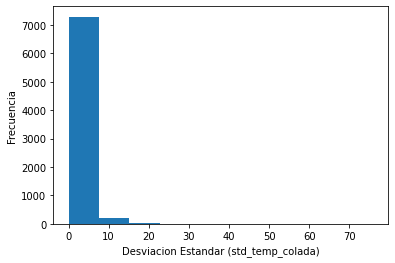

In [104]:
plt.hist(dfde['std_temp_colada'])
plt.ylabel('Frecuencia')
plt.xlabel('Desviacion Estandar (std_temp_colada)');
plt.savefig('stdtempcolada_HistSF.png', bbox_inches='tight') #Histograma sin filtro

In [105]:
#dfde=dfde.dropna()
#dfdeh2=dfdeh2.dropna()
#dfdeh3=dfdeh3.dropna()

dfde=dfde.dropna(subset=['std_temp_colada'])
dfdeh2=dfdeh2.dropna(subset=['std_temp_colada'])
dfdeh3=dfdeh3.dropna(subset=['std_temp_colada'])

print(dfde['std_temp_colada'].size)
print(dfdeh2['std_temp_colada'].size)
print(dfdeh3['std_temp_colada'].size)

#SIN QUITAR NAN se queda en 8920 (2469 y 6451)
#QUITANDO TODOS LOS NAN DE TODA LA BASE -> DE 8920 quedaron 7488 (1522 y 5966)
#QUITANDO TODOS LOS NAN SOLO DE LA COLUMNA std_temp_colada -> DE 8920 quedaron 7513 (1528 y 5985)

7513
1528
5985


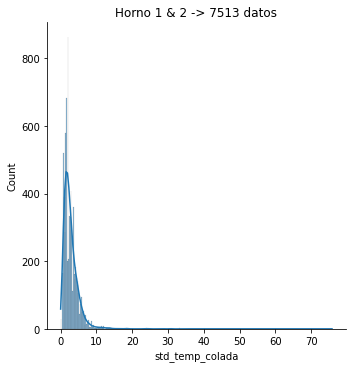

In [106]:
q25, q75 = np.percentile(dfde['std_temp_colada'], [25, 75])
bin_width = 2 * (q75 - q25) * len(dfde['std_temp_colada']) ** (-1/3)
bins = round(((dfde['std_temp_colada']).max() - (dfde['std_temp_colada']).min()) / bin_width)
#bins
#kde = st.gaussian_kde(Tarr[i])
sns.displot(dfde['std_temp_colada'], bins=bins, kde=True);
plt.title('Horno 1 & 2 -> '+str(len(dfde['std_temp_colada']))+' datos')
plt.savefig('stdtempcolada_Hist.png', bbox_inches='tight') # Histograma variable std_temp_colada despues de Filtro

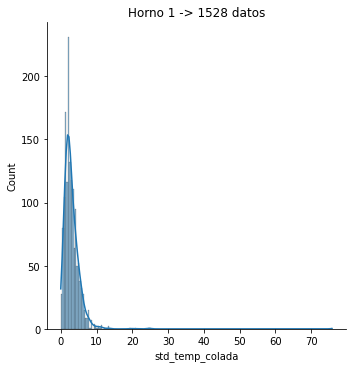

In [107]:
q25, q75 = np.percentile(dfdeh2['std_temp_colada'], [25, 75])
bin_width = 2 * (q75 - q25) * len(dfdeh2['std_temp_colada']) ** (-1/3)
bins = round(((dfdeh2['std_temp_colada']).max() - (dfdeh2['std_temp_colada']).min()) / bin_width)
#bins
#kde = st.gaussian_kde(Tarr[i])
sns.displot(dfdeh2['std_temp_colada'], bins=bins, kde=True);
plt.title('Horno 1 -> '+str(len(dfdeh2['std_temp_colada']))+' datos')

plt.savefig('stdtempcolada_H2.png', bbox_inches='tight') # Histograma variable std_temp_colada despues de Filtro

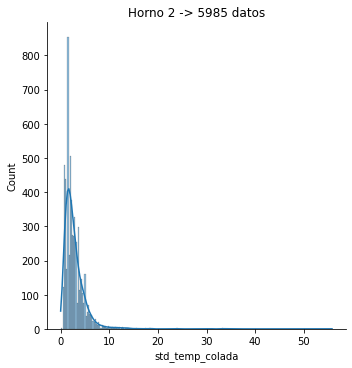

In [108]:
q25, q75 = np.percentile(dfdeh3['std_temp_colada'], [25, 75])
bin_width = 2 * (q75 - q25) * len(dfdeh3['std_temp_colada']) ** (-1/3)
bins = round(((dfdeh3['std_temp_colada']).max() - (dfdeh3['std_temp_colada']).min()) / bin_width)
#bins
#kde = st.gaussian_kde(Tarr[i])
sns.displot(dfdeh3['std_temp_colada'], bins=bins, kde=True);
plt.title('Horno 2 -> '+str(len(dfdeh3['std_temp_colada']))+' datos')

plt.savefig('stdtempcolada_H3.png', bbox_inches='tight') # Histograma variable std_temp_colada despues de Filtro

In [109]:
df=dfde.copy()
print(df.shape)

(7513, 15)


In [110]:
#FILTRO# * TEMPERATURE_CCM-TARGET: Filtramos por IQR para la desviación estandar del promedio en MCC
outDF = outliersIQR(df, col_name = "std_temp_colada").outliers()
df = outDF

print(df.shape)

(7199, 15)


## GRAFICAS DESVIACION ESTANDAR TRAS FILTRO

In [111]:
dfdeh2f=df.copy()
dfdeh3f=df.copy()
dfdeh2f=dfdeh2f[dfdeh2f['cla_horno']==2]
dfdeh3f=dfdeh3f[dfdeh3f['cla_horno']==3]

#LIMITES MIN Y MAX
print(dfde['std_temp_colada'].min())
print(dfde['std_temp_colada'].max())
print(df['std_temp_colada'].min())
print(df['std_temp_colada'].max())

0.0
75.84413842435903
0.0
6.715653356152339


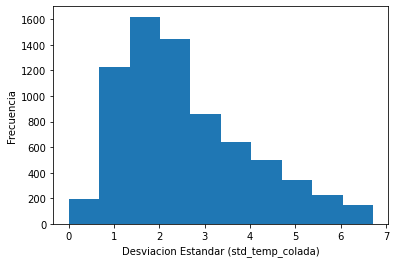

In [112]:
#EMR
plt.hist(df['std_temp_colada'])
plt.ylabel('Frecuencia')
plt.xlabel('Desviacion Estandar (std_temp_colada)');

#regla de Freedman–Diaconis para elegir de mejor manera el numero de bins o particiones
#q25, q75 = np.percentile(df['std_temp_colada'], [25, 75])
#bin_width = 2 * (q75 - q25) * len(df['std_temp_colada']) ** (-1/3)
#bins = round(((df['std_temp_colada']).max() - (df['std_temp_colada']).min()) / bin_width)
#print("Freedman–Diaconis number of bins:", bins)
#plt.hist(df['std_temp_colada'], bins=bins);

plt.savefig('stdtempcolada_HistCF.png', bbox_inches='tight') # Histograma variable std_temp_colada despues de Filtro


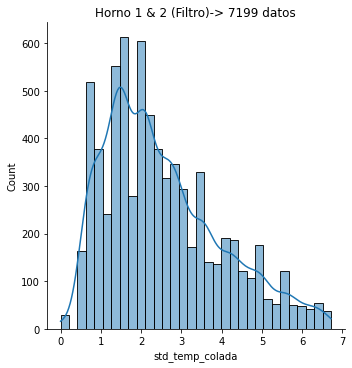

In [113]:
#EMR
import scipy.stats as st
import seaborn as sns

q25, q75 = np.percentile(df['std_temp_colada'], [25, 75])
bin_width = 2 * (q75 - q25) * len(df['std_temp_colada']) ** (-1/3)
bins = round(((df['std_temp_colada']).max() - (df['std_temp_colada']).min()) / bin_width)
#bins
#kde = st.gaussian_kde(Tarr[i])
sns.displot(df['std_temp_colada'], bins=bins, kde=True);
plt.title('Horno 1 & 2 (Filtro)-> '+str(len(df['std_temp_colada']))+' datos')

plt.savefig('stdtempcolada_HistCF_FDrule.png', bbox_inches='tight') # Histograma variable std_temp_colada despues de Filtro

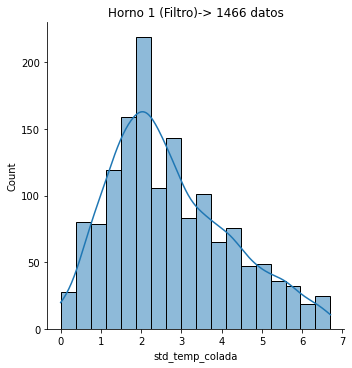

In [114]:
q25, q75 = np.percentile(dfdeh2f['std_temp_colada'], [25, 75])
bin_width = 2 * (q75 - q25) * len(dfdeh2f['std_temp_colada']) ** (-1/3)
bins = round(((dfdeh2f['std_temp_colada']).max() - (dfdeh2f['std_temp_colada']).min()) / bin_width)
#bins
#kde = st.gaussian_kde(Tarr[i])
sns.displot(dfdeh2f['std_temp_colada'], bins=bins, kde=True);
plt.title('Horno 1 (Filtro)-> '+str(len(dfdeh2f['std_temp_colada']))+' datos')

plt.savefig('stdtempcolada_HistCF_H2.png', bbox_inches='tight') # Histograma variable std_temp_colada despues de Filtro

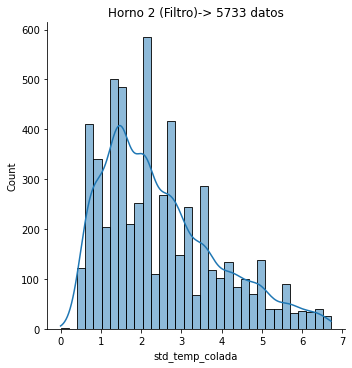

In [115]:
q25, q75 = np.percentile(dfdeh3f['std_temp_colada'], [25, 75])
bin_width = 2 * (q75 - q25) * len(dfdeh3f['std_temp_colada']) ** (-1/3)
bins = round(((dfdeh3f['std_temp_colada']).max() - (dfdeh3f['std_temp_colada']).min()) / bin_width)
#bins
#kde = st.gaussian_kde(Tarr[i])
sns.displot(dfdeh3f['std_temp_colada'], bins=bins, kde=True);
plt.title('Horno 2 (Filtro)-> '+str(len(dfdeh3f['std_temp_colada']))+' datos')

plt.savefig('stdtempcolada_HistCF_H3.png', bbox_inches='tight') # Histograma variable std_temp_colada despues de Filtro

## TABLA DATOS ELIMINADOS TRAS FILTROS

In [116]:
df[["std_temp_colada", "cla_horno"]].dropna().groupby("cla_horno").describe()

std_temp_colada                                              \
                    count      mean       std  min       25%      50%   
cla_horno                                                               
2                  1466.0  2.705671  1.486191  0.0  1.527525  2.44949   
3                  5733.0  2.472092  1.406842  0.0  1.414214  2.12132   

                               
                75%       max  
cla_horno                      
2          3.605551  6.701990  
3          3.257470  6.715653

In [117]:
Nfilt = df.groupby("cla_horno").size().values
resultados_limpieza = resultados_limpieza.append(pd.DataFrame({
    "descripcion": "Desv estandar de TEMPERATURE_CCM-TARGET: Filtramos por IQR",
    "H1": Nfilt[0], 
    "H2": Nfilt[1]}, index = [0]))
resultados_limpieza

,descripcion,H1,H2
0,Número de coladas por horno en datos de contro...,4176,14497
0,Coladas uniendo dataset preprocesado con Contr...,2806,9925
0,Eliminar si alguna de las variables calculadas...,2583,6889
0,Eliminar cuando ultima de afino - promedio mcc...,2487,6511
0,Eliminar cuando LADLE_LIFE = 1 o TUNDISH_HEAT_...,2469,6451
0,Desv estandar de TEMPERATURE_CCM-TARGET: Filtr...,1466,5733


In [118]:
df[["LADLE_EMPTY_TIME", "LADLE_FULL_TIME_CURRENT", "CASTING_TIME", "TRANSFER_TIME_RS_CCM"]].describe()

,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM
count,7199.000000,7199.000000,7199.000000,7199.000000
mean,113.872362,16.673605,46.344201,14.835651
std,203.870013,25.018306,24.555853,28.561360
min,0.033333,3.316667,8.000000,-0.049967
25%,50.600000,10.516667,42.000000,9.016667
50%,67.666667,13.816667,44.000000,12.233300
75%,86.183333,18.908333,48.000000,15.650017
max,1439.483333,1429.266667,1426.000000,1394.233367


In [119]:
# * Eliminar por IQR las variables de tiempo:
#     * LADLE_EMPTY_TIME <br>
#     * LADLE_FULL_TIME_CURRENT <br>
#     * CASTING_TIME-TARGET <br>
#     * TRANSFER_TIME_RS_CCM-TARGET <br>

dH1, dH2 = df[df["cla_horno"] == 2], df[df["cla_horno"] == 3]
print(dH1.shape, dH2.shape)

i = 1
df_tot_f = {}
for ele in [dH1, dH2]:
    print(f"\n******************** Horno {i} ****************************************************")
    iqrDF = ele.copy()
    for col in ["LADLE_EMPTY_TIME", "LADLE_FULL_TIME_CURRENT", "CASTING_TIME", "TRANSFER_TIME_RS_CCM"]:
        iqr = outliersIQR(iqrDF, col_name = col)
        iqrDF = iqr.outliers()
        
        print("------------------------------------")
        print(f"{col} --> inf: {iqr.lowlim: .2f}, sup:{iqr.uplim: .2f}")
        print(iqrDF.shape)
        resultados_limpieza = resultados_limpieza.append(pd.DataFrame({
            "descripcion": f"Eliminar por IQR {col}",
            f"H{i}": iqrDF.shape[0]}, index = [0]))
    df_tot_f[i] = iqrDF
    i+=1

(1466, 15) (5733, 15)

******************** Horno 1 ****************************************************
------------------------------------
LADLE_EMPTY_TIME --> inf:  2.51, sup: 126.89
(1284, 15)
------------------------------------
LADLE_FULL_TIME_CURRENT --> inf: -4.60, sup: 35.00
(1246, 15)
------------------------------------
CASTING_TIME --> inf:  30.00, sup: 54.00
(1201, 15)
------------------------------------
TRANSFER_TIME_RS_CCM --> inf:  1.23, sup: 19.90
(1187, 15)

******************** Horno 2 ****************************************************
------------------------------------
LADLE_EMPTY_TIME --> inf: -2.82, sup: 141.64
(5174, 15)
------------------------------------
LADLE_FULL_TIME_CURRENT --> inf: -1.81, sup: 31.06
(4892, 15)
------------------------------------
CASTING_TIME --> inf:  31.50, sup: 59.50
(4645, 15)
------------------------------------
TRANSFER_TIME_RS_CCM --> inf: -0.55, sup: 25.85
(4544, 15)


In [120]:
resultados_limpieza

,descripcion,H1,H2
0,Número de coladas por horno en datos de contro...,4176,14497
0,Coladas uniendo dataset preprocesado con Contr...,2806,9925
0,Eliminar si alguna de las variables calculadas...,2583,6889
0,Eliminar cuando ultima de afino - promedio mcc...,2487,6511
0,Eliminar cuando LADLE_LIFE = 1 o TUNDISH_HEAT_...,2469,6451
0,Desv estandar de TEMPERATURE_CCM-TARGET: Filtr...,1466,5733
0,Eliminar por IQR LADLE_EMPTY_TIME,1284,NaN
0,Eliminar por IQR LADLE_FULL_TIME_CURRENT,1246,NaN
0,Eliminar por IQR CASTING_TIME,1201,NaN
0,Eliminar por IQR TRANSFER_TIME_RS_CCM,1187,NaN


In [121]:
dataset = df_tot_f[1].append(df_tot_f[2])

In [122]:
dataset.describe()

,cla_horno,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,SH_promedio,first_afino,std_temp_colada,mean_temp_colada,last_afino
count,5731.000000,5731.000000,5729.000000,5731.000000,5731.000000,5731.000000,5731.000000,5731.000000,5713.000000,5713.000000,5731.000000,5731.000000,5731.000000,5731.000000
mean,2.792881,26.746990,51.109618,130.152770,64.726758,14.950995,44.627735,12.245751,1503.224466,28.937281,1543.921305,2.454045,1532.162726,1567.492584
std,0.405277,23.784192,29.844889,12.340927,23.733927,5.607466,4.645640,4.228966,11.925549,5.169340,26.205602,1.387019,12.672542,14.413468
min,2.000000,1.000000,2.000000,59.285400,0.033333,5.416667,31.000000,3.466667,1464.760880,13.150850,1287.000000,0.000000,1484.250000,1514.000000
25%,3.000000,11.000000,26.000000,123.829020,49.766667,10.433333,41.000000,8.999983,1497.197310,25.405150,1526.000000,1.414214,1524.000000,1558.000000
50%,3.000000,21.000000,50.000000,132.673950,65.116667,13.500000,44.000000,12.033333,1498.920860,28.693750,1543.000000,2.121320,1529.333333,1564.000000
75%,3.000000,34.000000,75.000000,135.936900,79.233333,17.958333,47.000000,15.116683,1508.325450,32.136650,1561.000000,3.214550,1538.000000,1574.000000
max,3.000000,148.000000,118.000000,212.278320,141.233333,34.966667,59.000000,25.566700,1530.629220,59.428423,1651.000000,6.715653,1573.750000,1650.000000


## Filtros por ingeniero de proceso

Filtros mínimos: 
* "LADLE_EMPTY_TIME": *20, 
* "LADLE_FULL_TIME_CURRENT": 5, 
* "CASTING_TIME": 25, 
* "TRANSFER_TIME_RS_CCM": 5
Filtros Máximos:
* "TUNDISH_HEAT_COUNTER": 60

In [123]:
(dataset["LADLE_EMPTY_TIME"] < 20).sum()

106

In [124]:
dataset[dataset["TUNDISH_HEAT_COUNTER"] > 60].groupby("cla_horno").size()

cla_horno
2    227
3    158
dtype: int64

In [125]:
# Solo usamos el filtro para esta variable
dataset = dataset[dataset["LADLE_EMPTY_TIME"] >= 20]

In [126]:
Nfilt = dataset.groupby("cla_horno").size().values
resultados_limpieza = resultados_limpieza.append(pd.DataFrame({
    "descripcion": "Filtros por ingeniero de proceso LADLE_EMPTY_TIME",
    "H1": Nfilt[0], 
    "H2": Nfilt[1]}, index = [0]))
resultados_limpieza

,descripcion,H1,H2
0,Número de coladas por horno en datos de contro...,4176,14497
0,Coladas uniendo dataset preprocesado con Contr...,2806,9925
0,Eliminar si alguna de las variables calculadas...,2583,6889
0,Eliminar cuando ultima de afino - promedio mcc...,2487,6511
0,Eliminar cuando LADLE_LIFE = 1 o TUNDISH_HEAT_...,2469,6451
0,Desv estandar de TEMPERATURE_CCM-TARGET: Filtr...,1466,5733
0,Eliminar por IQR LADLE_EMPTY_TIME,1284,NaN
0,Eliminar por IQR LADLE_FULL_TIME_CURRENT,1246,NaN
0,Eliminar por IQR CASTING_TIME,1201,NaN
0,Eliminar por IQR TRANSFER_TIME_RS_CCM,1187,NaN


In [127]:
# Filtramos de forma manual para TUNDISH_HEAT_COUNTER
dataset = dataset[dataset["TUNDISH_HEAT_COUNTER"] <= 60]

In [128]:
Nfilt = dataset.groupby("cla_horno").size().values
resultados_limpieza = resultados_limpieza.append(pd.DataFrame({
    "descripcion": "Filtros por ingeniero de proceso TUNDISH_HEAT_COUNTER",
    "H1": Nfilt[0], 
    "H2": Nfilt[1]}, index = [0]))
resultados_limpieza

,descripcion,H1,H2
0,Número de coladas por horno en datos de contro...,4176,14497
0,Coladas uniendo dataset preprocesado con Contr...,2806,9925
0,Eliminar si alguna de las variables calculadas...,2583,6889
0,Eliminar cuando ultima de afino - promedio mcc...,2487,6511
0,Eliminar cuando LADLE_LIFE = 1 o TUNDISH_HEAT_...,2469,6451
0,Desv estandar de TEMPERATURE_CCM-TARGET: Filtr...,1466,5733
0,Eliminar por IQR LADLE_EMPTY_TIME,1284,NaN
0,Eliminar por IQR LADLE_FULL_TIME_CURRENT,1246,NaN
0,Eliminar por IQR CASTING_TIME,1201,NaN
0,Eliminar por IQR TRANSFER_TIME_RS_CCM,1187,NaN


In [129]:
dataset.describe()

,cla_horno,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,SH_promedio,first_afino,std_temp_colada,mean_temp_colada,last_afino
count,5248.000000,5248.000000,5247.000000,5248.000000,5248.000000,5248.000000,5248.000000,5248.000000,5230.000000,5230.000000,5248.000000,5248.000000,5248.000000,5248.000000
mean,2.819931,21.815168,50.736421,130.665588,65.608629,14.898234,44.728840,12.310283,1502.713660,28.963421,1543.383765,2.448210,1531.679813,1566.975991
std,0.384281,13.559817,29.557979,12.160086,23.124426,5.568499,4.635149,4.236935,11.608386,5.229832,26.224417,1.384329,12.451954,14.125287
min,2.000000,1.000000,2.000000,73.707750,20.016667,5.416667,31.000000,3.466667,1465.094190,13.150850,1287.000000,0.000000,1484.250000,1514.000000
25%,3.000000,11.000000,26.000000,124.499340,50.579167,10.400000,41.237500,9.049992,1497.169455,25.355123,1525.000000,1.414214,1524.000000,1558.000000
50%,3.000000,20.000000,50.000000,132.981750,65.516667,13.450000,44.000000,12.116650,1498.838635,28.691396,1542.000000,2.121320,1529.000000,1564.000000
75%,3.000000,31.000000,74.000000,135.936900,79.654167,17.916667,47.000000,15.216642,1506.098260,32.238867,1560.000000,3.214550,1537.169643,1573.000000
max,3.000000,60.000000,118.000000,212.278320,141.233333,34.966667,59.000000,25.450000,1530.629220,59.428423,1651.000000,6.715653,1573.750000,1650.000000


In [130]:
dataset.groupby("cla_horno").max()["LADLE_LIFE"]

cla_horno
2    116.0
3    118.0
Name: LADLE_LIFE, dtype: float64

In [131]:
# temps = pd.read_csv("../../docs/Temperaturas_horno2.csv")

In [132]:
# temps[temps["cla_colada"].isin(df_tot_f.index)]

# Dataset final

In [133]:
## Dataframe de totales:
# TUNDISH_HEAT_COUNTER
# LADLE_LIFE
# LADLE_TOTAL_WEIGHT_RS
# LADLE_EMPTY_TIME
# LADLE_FULL_TIME_CURRENT
# CASTING_TIME-TARGET
# TRANSFER_TIME_RS_CCM-TARGET
# STEELGRADE_FAMILY------> NO APLICA
# LIQUIDUS_TEMPERATURE

## Datos de dataframe de temperaturas:
# TEMPERATURE_CCM-TARGET
# SECONDARY_REFINING_ARRIV_TEMP

# SUPERHEAT_TEMPERATURE-TARGET ------> CONSTANTE = 25 NO APLICA

In [134]:
dataset.head(2)

,cla_horno,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,nom_grado,SH_promedio,first_afino,std_temp_colada,mean_temp_colada,last_afino
cla_colada,,,,,,,,,,,,,,,
189462,2,29.0,24.0,112.64226,80.333333,7.633333,35.0,12.116633,1466.99827,1078 CG,28.50173,1512,0.707107,1495.5,1525
189466,2,4.0,2.0,115.60653,30.783333,6.600000,48.0,13.333367,1528.51518,1004 CEL,23.68482,1558,6.418723,1552.2,1605


In [135]:
dataset.reset_index(inplace = True)

In [136]:
dataset.shape

(5248, 16)

In [137]:
dataset["nom_grado"].unique()

array(['1078 CG', '1004 CEL', '1004 FW', '1006 SAE', '1008 SAE',
       '1008 SAE-IND', '1008 BCO', 'BS-1012', '1015 SAE', '1015 VAR',
       '1006 VDE CEL', 'BS-1010', '1026 MG', '1026 SAE', '1004 MBH CEL',
       '1018 SAE', '10B21', '1005 SAE', '1008 OPTIMUS', '1045', '1049 ST',
       '1055', '1060', '1060 H', '1065', '1070', '1074', '1008 TIS',
       '1012 IQ DA', '1010 SAE', '1021 SAE', '1004 FW TIS', '10B06',
       '1006 SW CEL', '1045 CAMESA', '1049 SP', '1018 Si', '1070 SP',
       '1077 TIS', '1036 QTB MX', '1006 VDE', '1074 Cr-V', '1078 Cr-V',
       '1010 IQ DA', '1011 R', 'EW2616-A', '1039', '1074 camesa',
       '1024 VAR', 'MTG60 3-4', '1049', '1028-2V', '1025-5VR',
       '1005 SAE-IND', 'A-36', '1039 VAR', '1028-4QTB', '1028-QTB',
       'A630', '1044 PTA', '1046-6', '1046-8 V', '1046-8V G52',
       '1038-10V', '1028 10V', '1036 PR', '1028-6V', 'A529 50 P',
       'A-36 G5', '1008 AMA', '1004 MB', '1020-6V', '1527 G56 QTB',
       '1012 TM', '1012 SAE', '1036-10 QTB

In [138]:
dataset = dataset[dataset["nom_grado"] != "PRUEBAS"]

In [139]:
dataset.dropna(inplace= True)

In [140]:
dataset.groupby("cla_horno").mean()

,cla_colada,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,SH_promedio,first_afino,std_temp_colada,mean_temp_colada,last_afino
cla_horno,,,,,,,,,,,,,,
2,190662.048884,19.231668,53.523911,116.294747,59.487442,15.258909,42.064825,10.629563,1511.982708,28.882808,1555.600425,2.670985,1540.865515,1577.721573
3,130200.577965,22.384921,50.154062,133.832619,66.955151,14.826362,45.310913,12.671424,1500.674024,28.979396,1540.665266,2.398695,1529.653421,1564.583567


In [141]:
dH1, dH2 = dataset[dataset["cla_horno"] == 2]["SH_promedio"], dataset[dataset["cla_horno"] == 3]["SH_promedio"]

In [142]:
dH1.shape[0], (dH1 <20).sum(), (dH1 > 30).sum(), ((dH1 >= 20)&(dH1<=30)).sum()

(941, 29, 367, 545)

In [143]:
dH2.shape[0], (dH2 <20).sum(), (dH2 > 30).sum(), ((dH2 >= 20)&(dH2<=30)).sum()

(4284, 146, 1727, 2411)

In [144]:
371/950

0.39052631578947367

In [145]:
# # Selección de variables para modelo

# dataset = dataset[["cla_colada", "TUNDISH_HEAT_COUNTER", "LADLE_LIFE", "LADLE_TOTAL_WEIGHT_RS", "LADLE_EMPTY_TIME",
#          "LADLE_FULL_TIME_CURRENT", "CASTING_TIME", "TRANSFER_TIME_RS_CCM", "t_liquidus", "cla_horno", "nom_grado",
#          "SH_promedio", "first_afino", "mean_temp_colada", "last_afino"]]

In [146]:
dataset.describe()

,cla_colada,cla_horno,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,SH_promedio,first_afino,std_temp_colada,mean_temp_colada,last_afino
count,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000
mean,141089.428517,2.819904,21.817033,50.760957,130.674124,65.610249,14.904262,44.726306,12.303694,1502.710669,28.962001,1543.355024,2.447733,1531.672671,1566.949665
std,23412.314390,0.384304,13.557723,29.550378,12.121779,23.107464,5.574841,4.630183,4.234004,11.612240,5.224315,26.245442,1.384571,12.454704,14.118169
min,125224.000000,2.000000,1.000000,2.000000,73.707750,20.016667,5.416667,31.000000,3.466667,1465.094190,13.150850,1287.000000,0.000000,1484.250000,1514.000000
25%,127930.000000,3.000000,11.000000,26.000000,124.499340,50.583333,10.400000,41.000000,9.049967,1497.168600,25.358460,1525.000000,1.414214,1524.000000,1558.000000
50%,130852.000000,3.000000,20.000000,50.000000,132.981750,65.516667,13.450000,44.000000,12.116633,1498.837350,28.693680,1542.000000,2.121320,1529.000000,1564.000000
75%,134887.000000,3.000000,31.000000,74.000000,136.356420,79.616667,17.933333,47.000000,15.216633,1506.099170,32.236699,1560.000000,3.214550,1537.142857,1573.000000
max,193761.000000,3.000000,60.000000,118.000000,212.278320,141.233333,34.966667,59.000000,25.450000,1530.629220,59.428423,1651.000000,6.715653,1573.750000,1650.000000


In [147]:
dataset.shape

(5225, 16)

In [148]:
# # Guardar dataset final
# dataset.to_csv("../../data/data_modelo/THA_finales/THA_dataset.csv", index = False)

In [149]:
#dataset

In [150]:
df.nom_grado.unique()


array(['1008 BCO', '1006 VDE CEL', '1015 VAR', 'A-36', '1036 QTB MX',
       '1028-6V', '1028-2V', '1046-6', '1044 PTA', '1039 VAR',
       '1028-4QTB', '1028-QTB', 'A630', '1025-5VR', '1046-8 V',
       '1046-8V G52', '1038-10V', '1028 10V', '1036 PR', 'A529 50 P',
       'A-36 G5', '1008 AMA', '1006 VDE', '1004 MB', '1020-6V',
       '1527 G56 QTB', '1004 CEL', '1006 SAE', '1008 SAE', '1012 TM',
       '1012 SAE', '1015 SAE', '1018 SAE', '1036-10 QTB', '1025 8V G56',
       'PRUEBAS', '1527 QTB-V', '1528 10QTB-V', '1024 VAR', '1028-6V CEL',
       '1078 CG', '1004 FW', '1008 SAE-IND', 'BS-1012', 'BS-1010',
       '1021 SAE', '1026 MG', '1026 SAE', '1006 SW CEL', '1004 MBH CEL',
       '10B21', '1005 SAE', '1004 FW TIS', '10B06', '1011 R', 'EW2616-A',
       '1008 OPTIMUS', '1039', '1045', '1049 ST', '1055', '1060',
       '1060 H', '1065', '1070', '1074', '1008 TIS', '1012 IQ DA',
       '1010 SAE', '1045 CAMESA', '1049 SP', '1018 Si', '1070 SP',
       '1077 TIS', '1074 Cr-V', '1078

## GENERACION HISTOGRAMA Para cada GRADO DE ACERO (NOMENCLATURA) con Super Heat > 30°C

In [151]:
#EMR
#GENERACION HISTOGRAMA Para cada GRADO DE ACERO (NOMENCLATURA) con Super Heat > 30°C
#dataset #esta variable tiene todos los datos finales del proceso

dsHSH = dataset[["cla_colada","nom_grado","SH_promedio","cla_horno"]].copy() # dsHSH <-> data set Histograma Super Heat
dsHSH=dsHSH.reset_index()
dsHSH=dsHSH.drop(['index'], axis=1)
#dsHSH = dsHSH[dsHSH["cla_horno"]==3]# (des)comentar para quedarnos con los datos de un horno u otro o ambos

dsHSH

,cla_colada,nom_grado,SH_promedio,cla_horno
0,189462,1078 CG,28.501730,2
1,189466,1004 CEL,23.684820,2
2,189467,1004 CEL,31.022260,2
3,189468,1004 CEL,20.783260,2
4,189470,1004 CEL,22.352810,2
...,...,...,...,...
5220,135547,1036-10 QTB,22.752246,3
5221,135549,1036-10 QTB,37.910410,3
5222,135550,1036-10 QTB,31.262967,3
5223,135551,1036-10 QTB,31.390810,3


In [152]:
nomgrad_cont=dsHSH['nom_grado'].value_counts()
nomgrad_cont=pd.DataFrame(nomgrad_cont)
#nomgrad_cont['nom_grado'].sum()
nomgrad_cont=nomgrad_cont.reset_index()
nomgrad_cont = nomgrad_cont.rename(columns={"nom_grado":"Totales"})
nomgrad_cont = nomgrad_cont.rename(columns={"index":"nom_grado"})
nomgrad_cont['Porcentaje Total (%)']=100*nomgrad_cont['Totales']/(nomgrad_cont['Totales'].sum())

dsHSH = dsHSH[dsHSH["SH_promedio"]>30]
dsHSH=dsHSH.reset_index()
dsHSH=dsHSH.drop(['index'], axis=1)

nomgrad_cont2=dsHSH['nom_grado'].value_counts()
nomgrad_cont2=pd.DataFrame(nomgrad_cont2)
nomgrad_cont2=nomgrad_cont2.reset_index()
nomgrad_cont2 = nomgrad_cont2.rename(columns={"nom_grado":"Totales > 30"})
nomgrad_cont2 = nomgrad_cont2.rename(columns={"index":"nom_grado2"})
nomgrad_cont2=nomgrad_cont2.drop(['nom_grado2'], axis=1)
nomgrad_cont2['Porcentaje Total > 30 (%)']=100*nomgrad_cont2['Totales > 30']/(nomgrad_cont2['Totales > 30'].sum())

nomgrad_cont = pd.concat([nomgrad_cont, nomgrad_cont2], axis=1)

nomgrad_cont['Porcentaje Grado']=100*nomgrad_cont['Totales > 30']/nomgrad_cont['Totales']
nomgrad_cont = nomgrad_cont.fillna(0)

nomgrad_cont.head(5)

,nom_grado,Totales,Porcentaje Total (%),Totales > 30,Porcentaje Total > 30 (%),Porcentaje Grado
0,1036 QTB MX,2324,44.478469,740.0,35.339064,31.841652
1,1028-4QTB,339,6.488038,185.0,8.834766,54.572271
2,1015 VAR,241,4.612440,175.0,8.357211,72.614108
3,1036 PR,218,4.172249,101.0,4.823305,46.330275
4,A-36,178,3.406699,95.0,4.536772,53.370787


In [153]:
#nomgrad_cont['Totales'].sum()/100
#Tabla con datos de numero de coladas > al 1% del total (que son aprox 5200), es decir nos quedamos con cada grado que tenga
#mas de 52 datos
nomgrad_cont=nomgrad_cont[nomgrad_cont['Totales']>=52]
nomgrad_cont

,nom_grado,Totales,Porcentaje Total (%),Totales > 30,Porcentaje Total > 30 (%),Porcentaje Grado
0,1036 QTB MX,2324,44.478469,740.0,35.339064,31.841652
1,1028-4QTB,339,6.488038,185.0,8.834766,54.572271
2,1015 VAR,241,4.612440,175.0,8.357211,72.614108
3,1036 PR,218,4.172249,101.0,4.823305,46.330275
4,A-36,178,3.406699,95.0,4.536772,53.370787
5,1046-6,134,2.564593,71.0,3.390640,52.985075
6,1028-6V,122,2.334928,52.0,2.483286,42.622951
7,1028-QTB,118,2.258373,50.0,2.387775,42.372881
8,1006 VDE CEL,111,2.124402,49.0,2.340019,44.144144
9,1036-10 QTB,106,2.028708,44.0,2.101242,41.509434


In [154]:
HistDataSH=nomgrad_cont.copy()
HistDataSH=HistDataSH.sort_values(by=['Porcentaje Grado'],ascending=False)
#HistDataSH.head(10)

HistDataSH=HistDataSH[['nom_grado','Totales','Porcentaje Grado']]
HistDataSH.to_excel("HistogramSH_Data.xlsx")

HistDataSH.head()


,nom_grado,Totales,Porcentaje Grado
2,1015 VAR,241,72.614108
1,1028-4QTB,339,54.572271
4,A-36,178,53.370787
5,1046-6,134,52.985075
18,1046-8 V,52,50.000000


In [216]:
#ValoresUnicos.head()
#colorsdf.head()
#print(type(colorsdf['Colores']))
type(colorines[0])## todo colorines es lista y un elemento es str

str

In [200]:
import matplotlib.pyplot as plt
import pandas as pd
from colour import Color

ValoresUnicos=HistDataSH['Porcentaje Grado'].unique() #Identificar los valores unicos de la tabla anterior
ValoresUnicos=pd.DataFrame(ValoresUnicos)
ValoresUnicos.head()

red = Color("red")
colors = list(red.range_to(Color("yellow"),len(ValoresUnicos)))
colors
colorsdf=pd.DataFrame(colors)
#colorsdf['x']=list(range(0,len(ValoresUnicos)))#
#colorsdf['y']=list(range(len(ValoresUnicos),len(ValoresUnicos)*2))#
colorsdf['Porcentaje Grado']=ValoresUnicos[0]

colorsdf = colorsdf.rename(columns={0:"Colores"})

colorines=colorsdf['Colores']
colorines=colorines.to_list()

for i in range(len(colorines)):
    colorines[i]=str(colorines[i])
    
#plt.bar(colorsdf.x, colorsdf["Porcentaje Grado"], color=colorines)#
#plt.show()#


#NO CORRER (AQUI SOLO ES PARA VISUALIZAR LA GRAFICA DE COLORES, ARRIBA SE COMENTARON PARA LAS GRAFICAS)
import matplotlib.pyplot as plt
import pandas as pd
from colour import Color

red = Color("red")
colors = list(red.range_to(Color("yellow"),len(ValoresUnicos)))
#colors = [color.rgb for color in colors]
colors
colorsdf=pd.DataFrame(colors)
colorsdf['x']=list(range(0,36))
colorsdf['y']=list(range(36,36*2))
colorsdf['Porcentaje Grado']=ValoresUnicos[0]

colorsdf = colorsdf.rename(columns={0:"Colores"})

colorines=colorsdf['Colores']
colorines=colorines.to_list()

for i in range(len(colorines)):
    colorines[i]=str(colorines[i])


    
plt.bar(colorsdf.x, colorsdf["Porcentaje Grado"], color=colorines)
plt.show()


In [201]:
colorsdf['Colores']=colorines
HistDataSH['Colores']=0

for i in range(len(HistDataSH)):
    for j in range(len(colorsdf)):
        if HistDataSH['Porcentaje Grado'][i]==colorsdf['Porcentaje Grado'][j]:
            #print(HistDataSH['Porcentaje Grado'][i],colorsdf['Porcentaje Grado'][j])
            HistDataSH['Colores'][i]=colorsdf['Colores'][j]   
#HistDataSH.tail()
liscolor=HistDataSH['Colores']
liscolor=liscolor.to_list()
#liscolor

/tmp/ipykernel_333119/616029998.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HistDataSH['Colores'][i]=colorsdf['Colores'][j]
/opt/jupyterhub/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#NO CORRER (NO ES NECESARIO)
import matplotlib.colorbar as colorbar
import matplotlib.colors as clr
import matplotlib.pyplot as plt

cb_colors = liscolor#["#000000", "#808000", "#D3D3D3", "#FFFFFF", "#000080", "#FF4500", "#696969", "#FFFFE0"]
num_colors = len(cb_colors)
cmap_ = clr.ListedColormap(cb_colors)

fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = colorbar.ColorbarBase(ax, orientation='horizontal',
                           cmap=cmap_, norm=plt.Normalize(-0.5, num_colors - 0.5))

cb.set_ticks(range(num_colors))
#cb.ax.set_xticklabels(["A", "B", "C", "D", "E", "F", "G", "H"])
plt.show()

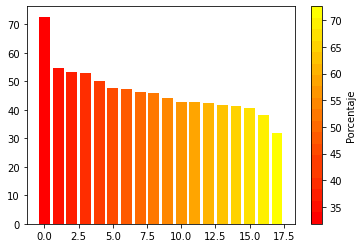

In [202]:
import matplotlib.colors as clr
import matplotlib.colorbar as colorbar
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

y = colorsdf['Porcentaje Grado']
colors = cm.hsv(y / float(max(y)))
cb_colors = liscolor
fig, ax = plt.subplots()
plot = ax.scatter(y, y, c = y, cmap= clr.ListedColormap(cb_colors))
plt.cla()
ax.bar(range(len(y)), y, color = colorines)

#cbaxes = inset_axes(ax, width="100%", height="10%", loc=2)
#plt.colorbar(plot, cax=cbaxes, orientation='horizontal')

fig.colorbar(plot, ax=ax, label="Porcentaje")


In [203]:
#Ejecutar cuando queramos acomodar y ordenar los datos por cierta columna
HistDataSH=HistDataSH.sort_values(by=['Porcentaje Grado'],ascending=False)
liscolor=HistDataSH['Colores'].to_list()

HistDataSH.head()
#listcolors2

,nom_grado,Totales,Porcentaje Grado,Colores
2,1015 VAR,241,72.614108,red
1,1028-4QTB,339,54.572271,#ff0f00
4,A-36,178,53.370787,#ff1e00
5,1046-6,134,52.985075,#ff2d00
18,1046-8 V,52,50.000000,#ff3c00


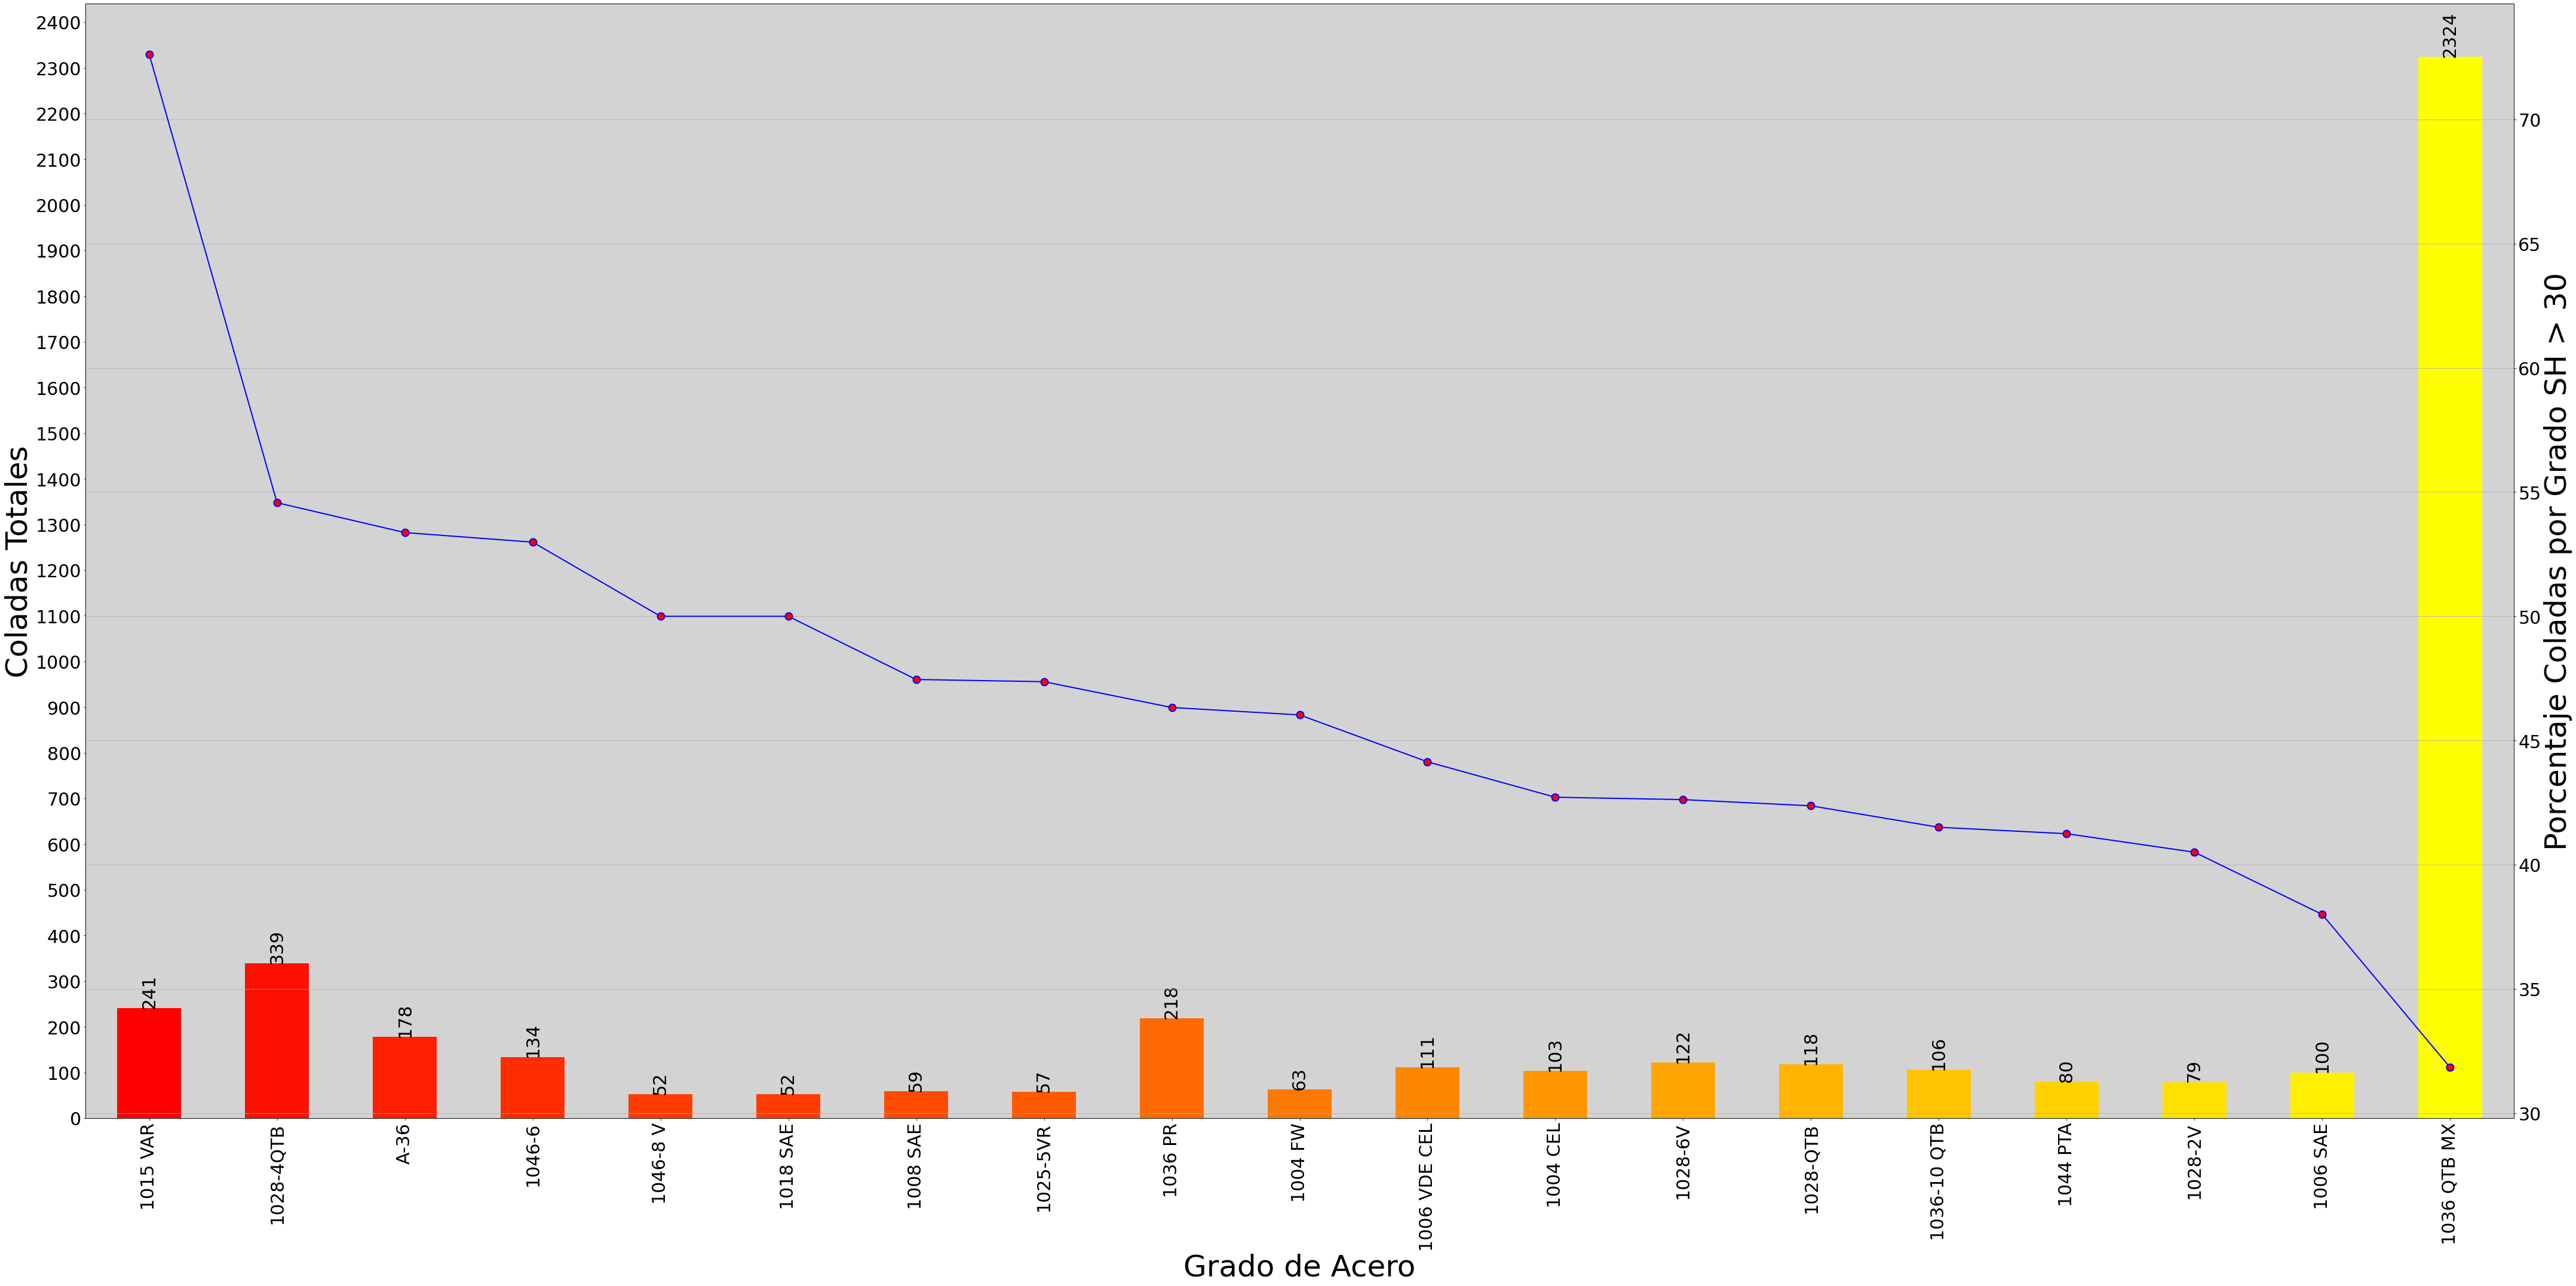

In [204]:
#fig = plt.figure(figsize = (30, 30))
ax = HistDataSH.plot(x='nom_grado', y='Totales', kind='bar', legend=False, rot=90, figsize = (60, 30),color=liscolor)
ax.set_facecolor('lightgray')

ax.bar_label(ax.containers[0], label_type='edge', rotation=90, size=30)

plt.xlabel('Grado de Acero', size=50)
plt.ylabel('Coladas Totales', size=50)

plt.xticks(rotation=90, size=30)
plt.yticks(np.arange(0,2500,100.0),rotation=0, size=30)


#fig.colorbar(plot, ax=ax, label="Porcentaje")


ax12 = ax.twinx()
ax12.plot(HistDataSH['nom_grado'], HistDataSH['Porcentaje Grado'], 'o-', color="blue", markersize=12, markerfacecolor='red', markeredgewidth=2, linewidth=2)
#ax.bar_label(ax.containers[0], label_type='edge', rotation=90, size=15)

plt.ylabel('Porcentaje Coladas por Grado SH > 30', size=50)
plt.yticks(rotation=0, size=30)
#plt.ylim([0, 100])

plt.tight_layout()
plt.grid()
plt.savefig('Barplot_SteelGrade_GradientPercentage.png', bbox_inches='tight')

#plt.show()

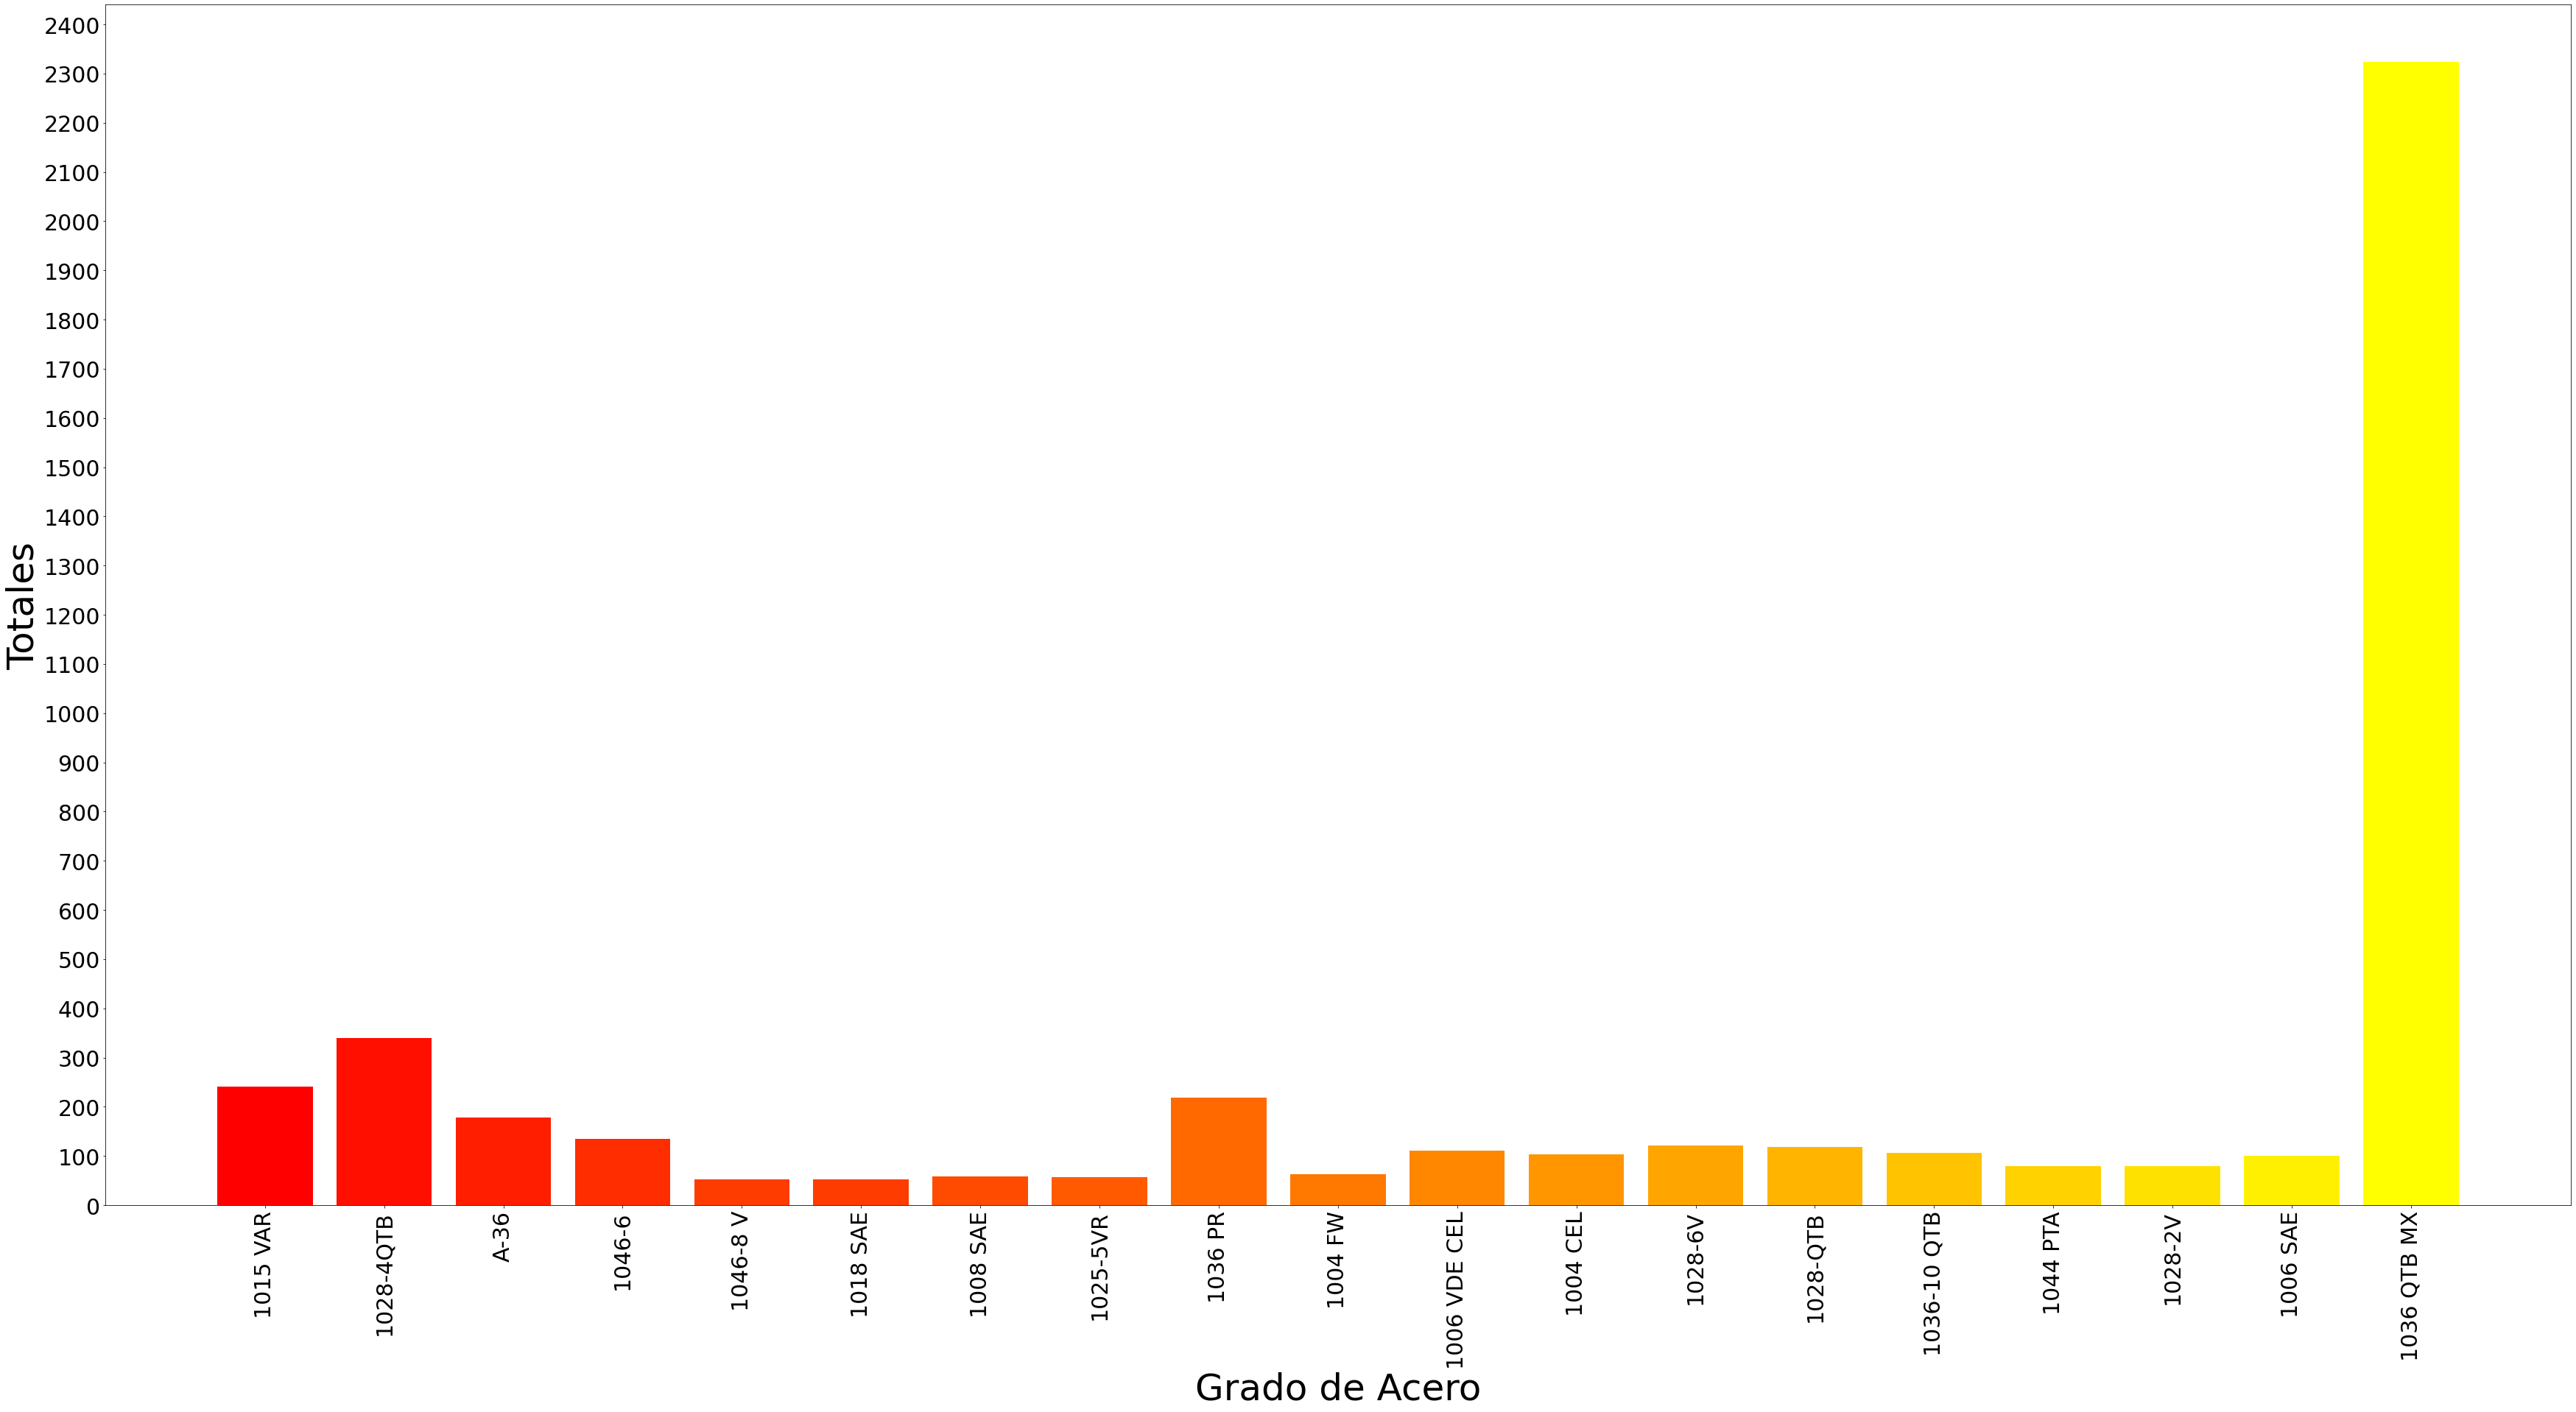

In [205]:
fig = plt.figure(figsize = (60, 30))
plt.bar(HistDataSH.nom_grado,HistDataSH["Totales"],color=liscolor)
plt.xlabel('Grado de Acero', size=50)
plt.ylabel('Totales', size=50)

plt.xticks(rotation=90, size=30)
plt.yticks(np.arange(0,2500,100.0),rotation=0, size=30)



#plt.xticks(np.arange(min(x), max(x)+1, 3.0))
#plt.ylim(0, 2500)
plt.savefig('Barplot_SteelGrade_GradientPercentage.png', bbox_inches='tight')

plt.show()

In [161]:
dfu=df.nom_grado.unique()
dfu = pd.DataFrame(dfu)
dfu = dfu.rename(columns={0:"nom_grado"})
#pd.set_option("max_rows", None)
dfu.head()

,nom_grado
0,1008 BCO
1,1006 VDE CEL
2,1015 VAR
3,A-36
4,1036 QTB MX


In [162]:
print(len(nomgrad_cont['nom_grado']))
print(len(dsHSH))

19
2094


In [163]:
sarr=[]#subarrays (un grado de acero)
Sarr=[]#super array (todos los grados de acero)
ct=0
for i in range(len(nomgrad_cont['nom_grado'])):
  #print("nom_grado",dfu['nom_grado'][i])
  #ct=0
  for j in range(len(dsHSH)):
    if dsHSH['nom_grado'][j]==nomgrad_cont['nom_grado'][i]:
      #print(dsHSH['nom_grado'][j],ct,dsHSH['SH_promedio'][j])
      ct=ct+1
      sarr.append(dsHSH['SH_promedio'][j])
  #despues del 2do for
  #sarr=np.array(sarr)#esta se tiene que qedar para que sea array / sin esta quedan como listas
  Sarr.append(sarr)
  sarr=[]

#Sarr

In [164]:
#Aqui solo nos quedamos con los conjuntos de coladas para cada grado mayores a 60 datos, el resto se elimina
Tarr=Sarr.copy()
for item in Tarr.copy():
    if len(item) < 60:
        Tarr.remove(item)
len(Tarr)

6

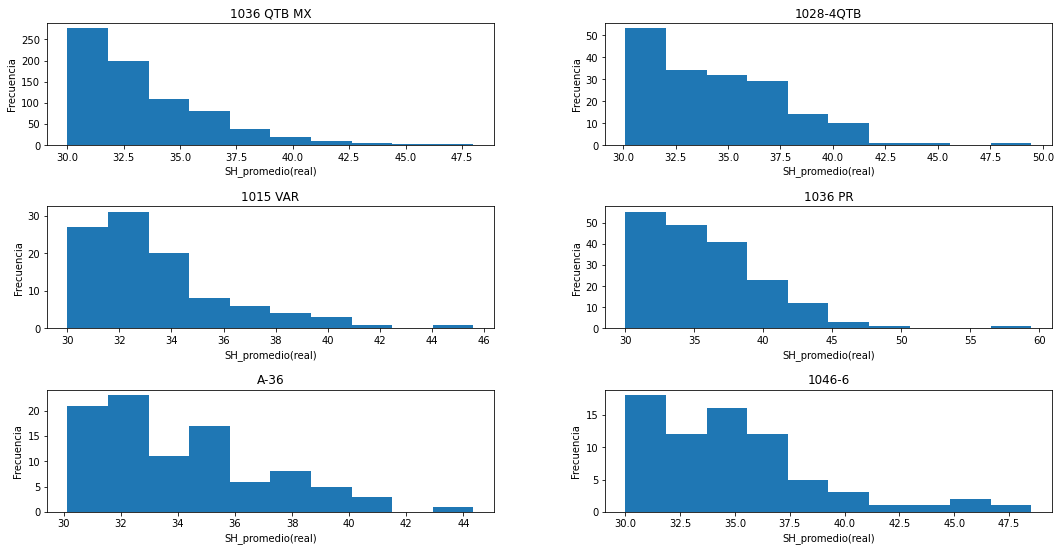

In [165]:
fig, axs = plt.subplots(3,2, figsize=(18, 9), facecolor='w', edgecolor='k') #3,2 es por la cantidad de nom_grado a tener en cuenta
fig.subplots_adjust(hspace = 0.5, wspace=0.25)

axs = axs.ravel()

for i in range(len(Tarr)):
    axs[i].hist(Tarr[i])
    #axs[i].hist(AG[i], bins=20)
    axs[i].set(xlabel='SH_promedio(real)', ylabel='Frecuencia')
    axs[i].set_title(str(nomgrad_cont['nom_grado'][i]))

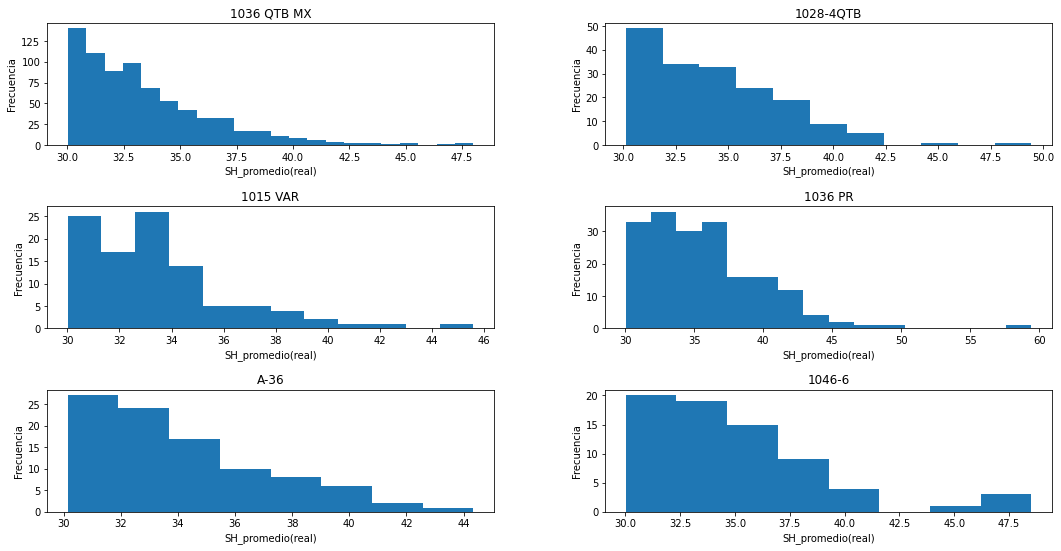

In [166]:
#EMR lo mismo de lo anterior pero con la regla freedman-diaconis para ver el mejor numero de bins
fig, axs = plt.subplots(3,2, figsize=(18, 9), facecolor='w', edgecolor='k') #3,2 es por la cantidad de nom_grado a tener en cuenta
fig.subplots_adjust(hspace = 0.5, wspace=0.25)

axs = axs.ravel()

for i in range(len(Tarr)):
    #axs[i].hist(Tarr[i])
    ###axs[i].hist(AG[i], bins=20)
    #axs[i].set(xlabel='SH_promedio(real)', ylabel='Frecuencia')
    #axs[i].set_title(str(dfu["nom_grado"][i]))
    
    q25, q75 = np.percentile(Tarr[i], [25, 75])
    bin_width = 2 * (q75 - q25) * len(Tarr[i]) ** (-1/3)
    bins = round((max(Tarr[i]) - min(Tarr[i])) / bin_width)
    #print("Freedman–Diaconis number of bins:", bins)
    axs[i].hist(Tarr[i], bins=bins);
    axs[i].set(xlabel='SH_promedio(real)', ylabel='Frecuencia')
    axs[i].set_title(str(nomgrad_cont['nom_grado'][i]))

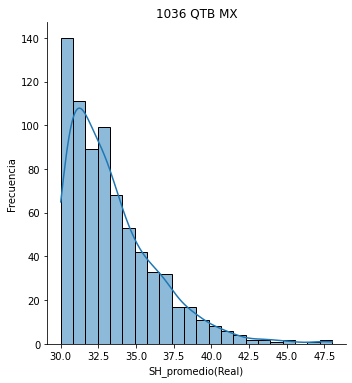

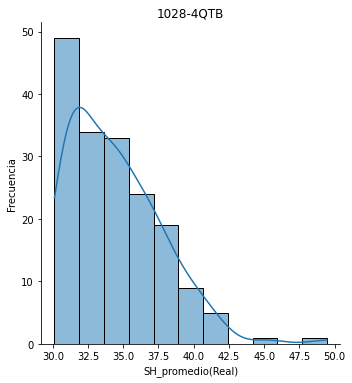

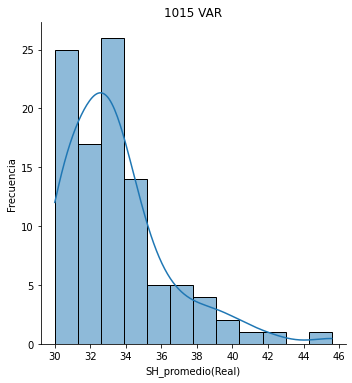

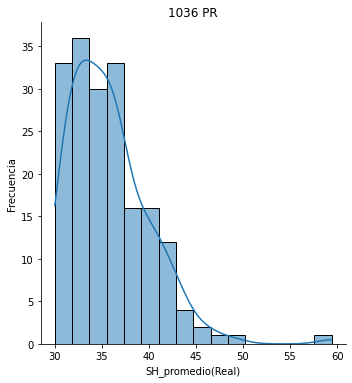

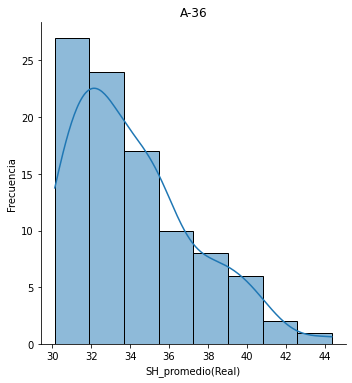

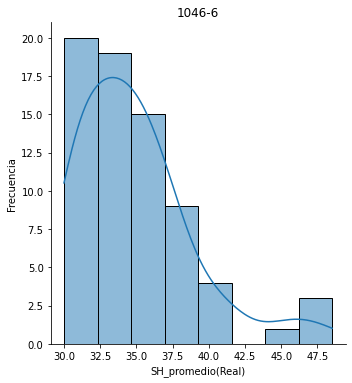

In [167]:
#EMR lo mismo de lo anterior pero con la regla freedman-diaconis para ver el mejor numero de bins
#fig, axs = plt.subplots(3,2, figsize=(18, 9), facecolor='w', edgecolor='k') #3,2 es por la cantidad de nom_grado a tener en cuenta
#fig.subplots_adjust(hspace = 0.5, wspace=0.25)

#axs = axs.ravel()

for i in range(len(Tarr)):
    #axs[i].hist(Tarr[i])
    ###axs[i].hist(AG[i], bins=20)
    #axs[i].set(xlabel='SH_promedio(real)', ylabel='Frecuencia')
    #axs[i].set_title(str(dfu["nom_grado"][i]))
    
    q25, q75 = np.percentile(Tarr[i], [25, 75])
    bin_width = 2 * (q75 - q25) * len(Tarr[i]) ** (-1/3)
    bins = round((max(Tarr[i]) - min(Tarr[i])) / bin_width)
    ##print("Freedman–Diaconis number of bins:", bins)
    #axs[i].hist(Tarr[i], bins=bins);
    #axs[i].set(xlabel='SH_promedio(real)', ylabel='Frecuencia')
    #axs[i].set_title(str(dfu["nom_grado"][i]))
    
    #axs[i].hist(Tarr[i], density=False, bins=bins, label="Data")
    #mn, mx = plt.xlim()
    #axsplt.xlim(mn, mx)
    #kde_xs = np.linspace(mn, mx, 300)
    kde = st.gaussian_kde(Tarr[i])
    #axs[i].plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    #axs[i].plt.legend(loc="upper left")
    #axs[i].plt.ylabel("Probability")
    #axs[i].plt.xlabel("Data")
    #axs[i].plt.title("Histogram");
    
    sns.displot(Tarr[i], bins=bins, kde=True);
    plt.title(str(nomgrad_cont['nom_grado'][i]))
    plt.xlabel("SH_promedio(Real)")
    plt.ylabel("Frecuencia")

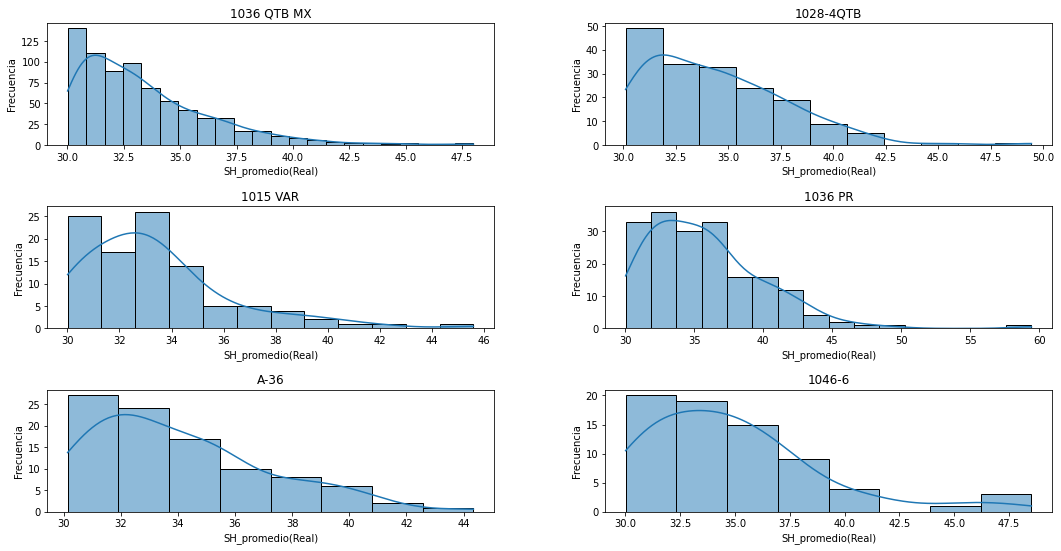

In [168]:
f = plt.figure(figsize=(18, 9))
f.subplots_adjust(hspace = 0.5, wspace=0.25)

for i in range(len(Tarr)):
    f.add_subplot(3, 2, i+1)
    q25, q75 = np.percentile(Tarr[i], [25, 75])
    bin_width = 2 * (q75 - q25) * len(Tarr[i]) ** (-1/3)
    bins = round((max(Tarr[i]) - min(Tarr[i])) / bin_width)
    kde = st.gaussian_kde(Tarr[i])
    sns.histplot(Tarr[i], bins=bins, kde=True);
    plt.title(str(nomgrad_cont['nom_grado'][i]))
    plt.xlabel("SH_promedio(Real)")
    plt.ylabel("Frecuencia")
    plt.show
    #sns.displot(Tarr[i], bins=bins)
plt.savefig('nomgrado_hist.png', bbox_inches='tight')
#Guardar HISTOGRAMAS Para cada GRADO DE ACERO (NOMENCLATURA) con Super Heat > 30°C y con numero de coladas>60


In [169]:
gk=dsHSH.groupby(['nom_grado','cla_colada'])
gk.first()
#gk.get_group('1004 CEL')

SH_promedio  cla_horno
nom_grado cla_colada                        
1004 CEL  128656        31.892263          3
          128728        35.333940          3
          189467        31.022260          2
          189588        30.313780          2
          189610        33.170770          2
...                           ...        ...
MTG60 3-4 192060        32.797650          2
          192063        31.177160          2
          192064        30.301483          2
          192065        31.945620          2
          192066        30.977120          2

[2094 rows x 2 columns]

## ANALISIS ADICIONALES


# Analisis adicionales
El objetivo es tener los siguientes datos para cada grado de acero:

Temperatura en colada real

* Dispersión  (valor medio – 1 sigma y valor medio + 1 sigma) para 1 sigma (70 % de la población)
* % de muestras menores al valor medio – 1 sigma
* % de muestras mayores al valor medio + 1 sigma

Liquidus real

* Dispersión  (valor medio – 1 sigma y valor medio + 1 sigma) para 1 sigma (70 % de la población)
* % de muestras menores al valor medio – 1 sigma
* % de muestras mayores al valor medio + 1 sigma

Superheat real

* Dispersión  (valor medio – 1 sigma y valor medio + 1 sigma) para 1 sigma (70 % de la población)
* % de muestras menores al valor medio – 1 sigma
* % de muestras mayores al valor medio + 1 sigma


In [170]:
data_h2 = dataset[dataset["cla_horno"] == 3]

In [171]:
data_h2.head(1)

,cla_colada,cla_horno,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,nom_grado,SH_promedio,first_afino,std_temp_colada,mean_temp_colada,last_afino
945,125224,3,26.0,50.0,151.17777,97.55,23.866667,54.0,9.566633,1524.17945,1008 BCO,28.82055,1532,2.581989,1553.0,1593


In [172]:
data_h2["Sheat"] = data_h2["mean_temp_colada"] - data_h2["t_liquidus"]

/tmp/ipykernel_333119/476011756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_h2["Sheat"] = data_h2["mean_temp_colada"] - data_h2["t_liquidus"]


In [173]:
data_h2["Sheat"].describe()

count    4284.000000
mean       28.979396
std         5.243092
min        13.150850
25%        25.359218
50%        28.684205
75%        32.268320
max        59.428423
Name: Sheat, dtype: float64

In [174]:
# resultados = pd.DataFrame(columns = ["nom_grado", 
#                         "T_mcc_real_mean-1sigma", 
#                         "T_mcc_real_mean+1sigma",
#                         "T_mcc_real_%inf_out",
#                         "T_mcc_real_%sup_out",
#                         "T_liq_real_mean-1sigma",
#                         "T_liq_real_mean+1sigma",
#                         "T_liq_real_%inf_out",
#                         "T_liq_real_%sup_out",
#                         "Sheat_mean-1sigma",
#                         "Sheat_mean+1sigma",
#                         "Sheat_%inf_out", 
#                         "Sheat_%sup_out",
#                        ])
resultados = pd.DataFrame(columns = ["nom_grado", 
                        "N_coladas",
                        "T_mcc_real_mean", 
                        "T_mcc_real_sigma",
                        "T_mcc_real_%inf_out",
                        "T_mcc_real_%sup_out",
                        "T_liq_real_mean",
                        "T_liq_real_sigma",
                        "T_liq_real_%inf_out",
                        "T_liq_real_%sup_out",
                        "Sheat_mean",
                        "Sheat_sigma",
                        "Sheat_%inf_out", 
                        "Sheat_%sup_out",
                       ])
resultados

,nom_grado,N_coladas,T_mcc_real_mean,T_mcc_real_sigma,T_mcc_real_%inf_out,T_mcc_real_%sup_out,T_liq_real_mean,T_liq_real_sigma,T_liq_real_%inf_out,T_liq_real_%sup_out,Sheat_mean,Sheat_sigma,Sheat_%inf_out,Sheat_%sup_out


In [175]:
grupos = data_h2.groupby("nom_grado").size()

In [176]:
grupos.index

Index(['1004 CEL', '1004 MB', '1006 SAE', '1006 VDE', '1006 VDE CEL',
       '1008 AMA', '1008 BCO', '1008 SAE', '1012 SAE', '1012 TM', '1015 SAE',
       '1015 VAR', '1018 SAE', '1020-6V', '1024 VAR', '1025-5VR', '1028 10V',
       '1028-2V', '1028-4QTB', '1028-6V', '1028-6V CEL', '1028-QTB', '1036 PR',
       '1036 QTB MX', '1036-10 QTB', '1038-10V', '1039 VAR', '1044 PTA',
       '1046-6', '1046-8 V', '1046-8V G52', '1527 G56 QTB', '1527 QTB-V',
       '1528 10QTB-V', 'A-36', 'A-36 G5', 'A529 50 P', 'A630'],
      dtype='object', name='nom_grado')

In [177]:
resultados["nom_grado"] = grupos.index.to_list()

In [178]:
def dispersion(data, column):
    v = data[column]
    std = v.std()
    mean = v.mean()
    sup = (v > (mean + std)).sum()
    inf = (v < (mean - std)).sum()
    prc_inf =  np.round(inf*100/len(v), 2)
    prc_sup = np.round(sup*100/len(v), 2)
    return prc_inf, prc_sup

In [179]:
for i, gr in enumerate(grupos.index):
    df_temporal = data_h2[data_h2["nom_grado"] == gr]
    resultados.iloc[i, 1] = df_temporal.shape[0]
    for j, col in enumerate(["mean_temp_colada", "t_liquidus", "Sheat"]):
        inf, sup = dispersion(df_temporal, col)
        mean = df_temporal[col].mean()
        std = df_temporal[col].std()
        resultados.iloc[i, j*4+2] = mean
        resultados.iloc[i, j*4+3] = std
        resultados.iloc[i, j*4+4] = inf
        resultados.iloc[i, j*4+5] = sup

In [180]:
resultados.sort_values('N_coladas',ascending=False,inplace=True)

In [181]:
print(100*(resultados['N_coladas']/4284))

23    53.618114
18     7.913165
22     5.088702
34     4.154995
28     3.127918
11     3.104575
19     2.847806
21     2.754435
24     2.474323
27     1.867414
17     1.820728
4      1.493931
15      1.30719
29     1.213819
26     0.887021
37     0.770308
36      0.70028
35     0.676937
13     0.560224
2      0.560224
6      0.466853
20     0.373483
31      0.35014
1       0.35014
0      0.280112
10     0.256769
12     0.186741
3      0.163399
7      0.140056
8      0.093371
9      0.093371
25     0.070028
5      0.070028
32     0.046685
33     0.046685
14     0.023343
30     0.023343
16     0.023343
Name: N_coladas, dtype: object


In [182]:
resultados.to_csv("Analisis_grado_acero.csv")

In [183]:
resultados

,nom_grado,N_coladas,T_mcc_real_mean,T_mcc_real_sigma,T_mcc_real_%inf_out,T_mcc_real_%sup_out,T_liq_real_mean,T_liq_real_sigma,T_liq_real_%inf_out,T_liq_real_%sup_out,Sheat_mean,Sheat_sigma,Sheat_%inf_out,Sheat_%sup_out
23,1036 QTB MX,2297,1525.995476,4.638849,14.5,15.67,1498.050212,1.2655,13.8,12.49,27.945264,4.821918,14.67,15.45
18,1028-4QTB,339,1533.893956,5.008511,15.04,16.22,1503.416159,1.015187,13.57,11.8,30.477797,5.096574,14.75,16.81
22,1036 PR,218,1527.334561,5.33424,11.47,13.3,1493.041754,1.395416,11.01,11.01,34.292807,5.51109,11.93,16.06
34,A-36,178,1537.143853,5.037369,16.85,18.54,1509.559744,0.971334,11.24,14.04,27.584109,5.146847,16.85,16.85
28,1046-6,134,1520.840047,4.23042,17.16,16.42,1488.777418,0.996145,17.16,17.91,32.062629,4.269129,17.91,13.43
11,1015 VAR,133,1545.555993,4.728204,14.29,14.29,1517.441418,1.269341,13.53,14.29,28.114575,4.81241,17.29,15.04
19,1028-6V,122,1533.231656,5.27342,15.57,13.93,1501.887567,1.01421,17.21,9.84,31.344089,5.455619,16.39,13.93
21,1028-QTB,118,1533.990604,4.568682,11.02,11.86,1505.191534,1.050342,14.41,11.86,28.799069,4.606598,12.71,11.86
24,1036-10 QTB,106,1526.740779,5.235051,16.04,14.15,1497.163973,1.286578,13.21,12.26,29.576806,5.472846,16.98,13.21
27,1044 PTA,80,1521.431169,4.82648,13.75,11.25,1489.883221,1.491155,13.75,13.75,31.547948,4.889938,13.75,16.25


Text(0.5, 0, 'Temperatura en MCC')

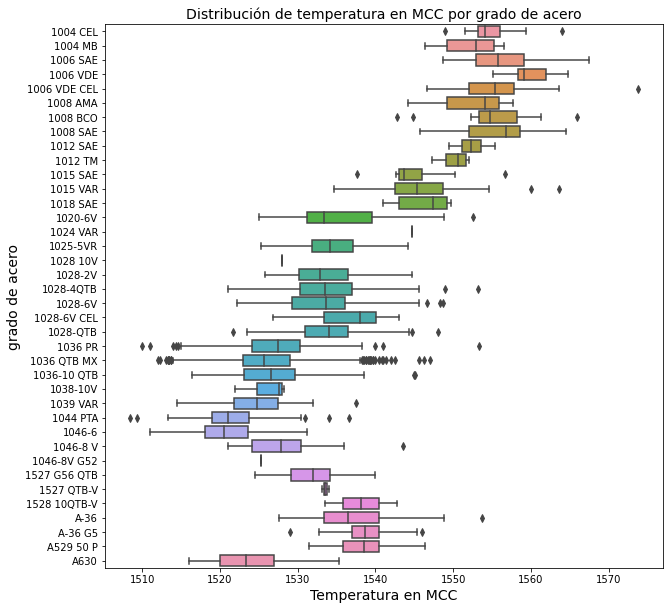

In [184]:
plt.figure(figsize = (10,10))
sns.boxplot(y = "nom_grado", x = "mean_temp_colada", data = data_h2, orient = "h", order = grupos.index)
plt.title("Distribución de temperatura en MCC por grado de acero", fontsize = 14)
plt.ylabel("grado de acero", fontsize = 14)
plt.xlabel("Temperatura en MCC", fontsize = 14)

In [185]:
grupos = pd.DataFrame(grupos, columns = ["N coladas"])
grupos = grupos.assign(temperatura_promedio = data_h2.groupby("nom_grado").mean()["mean_temp_colada"].values)
grupos = grupos.assign(sigma = data_h2.groupby("nom_grado").std()["mean_temp_colada"].values)
grupos = grupos.assign(q25 = data_h2.groupby("nom_grado").quantile(0.25)["mean_temp_colada"].values)
grupos = grupos.assign(q75 = data_h2.groupby("nom_grado").quantile(0.75)["mean_temp_colada"].values)
grupos = grupos.assign(iqr = (grupos["q75"] - grupos["q25"]) * 1.5)
grupos

,N coladas,temperatura_promedio,sigma,q25,q75,iqr
nom_grado,,,,,,
1004 CEL,12,1554.920833,3.844379,1553.187500,1555.975000,4.181250
1004 MB,15,1552.265556,3.373899,1549.166667,1555.291667,9.187500
1006 SAE,24,1556.288194,4.478813,1552.916667,1559.083333,9.250000
1006 VDE,7,1559.946429,3.367938,1558.333333,1561.937500,5.406250
1006 VDE CEL,64,1555.345838,4.616991,1552.000000,1557.875000,8.812500
1008 AMA,3,1552.027778,6.959373,1549.208333,1555.916667,10.062500
1008 BCO,20,1555.088472,5.079558,1553.375000,1558.270833,7.343750
1008 SAE,6,1555.577778,6.556139,1552.000000,1558.625000,9.937500
1012 SAE,4,1552.375000,2.443339,1551.125000,1553.583333,3.687500


In [186]:
grupos["limite_inf"] = grupos["q25"] - grupos["iqr"]
grupos["limite_sup"] = grupos["q75"] + grupos["iqr"]

In [187]:
grupos_limites = dict(zip(grupos.index, grupos[["limite_inf", "limite_sup"]].values))

In [188]:
grupos["n_outilers"] = 0

In [189]:
grupos_limites["1004 CEL"]

array([1549.00625, 1560.15625])

In [190]:
for nom, limits in grupos_limites.items():
    df_temporal = data_h2[data_h2["nom_grado"] == nom]["mean_temp_colada"]
    inferior = (df_temporal < limits[0]).sum()
    superior = (df_temporal > limits[1]).sum()
    grupos.loc[nom, "n_outilers"] = inferior + superior

In [191]:
grupos["prc_outliers"] = grupos["n_outilers"] * 100 / grupos["N coladas"]

In [192]:
grupos_limites

{'1004 CEL': array([1549.00625, 1560.15625]),
 '1004 MB': array([1539.97916667, 1564.47916667]),
 '1006 SAE': array([1543.66666667, 1568.33333333]),
 '1006 VDE': array([1552.92708333, 1567.34375   ]),
 '1006 VDE CEL': array([1543.1875, 1566.6875]),
 '1008 AMA': array([1539.14583333, 1565.97916667]),
 '1008 BCO': array([1546.03125   , 1565.61458333]),
 '1008 SAE': array([1542.0625, 1568.5625]),
 '1012 SAE': array([1547.4375    , 1557.27083333]),
 '1012 TM': array([1545.27083333, 1555.4375    ]),
 '1015 SAE': array([1538.5, 1550.5]),
 '1015 VAR': array([1533.25      , 1557.91666667]),
 '1018 SAE': array([1533.75      , 1558.41666667]),
 '1020-6V': array([1518.8125    , 1551.97916667]),
 '1024 VAR': array([1544.66666667, 1544.66666667]),
 '1025-5VR': array([1524.15104167, 1544.859375  ]),
 '1028 10V': array([1528., 1528.]),
 '1028-2V': array([1520.58928571, 1546.01785714]),
 '1028-4QTB': array([1520.33333333, 1547.        ]),
 '1028-6V': array([1519.19270833, 1546.234375  ]),
 '1028-6V CE